In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-14 20:37:38.834949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load Koch Meinhardt dataset

- $D_a = 0.005, \quad D_s=0.2$.
- $\mu_a = 0.01$.
- $\sigma_a = 0.0, \quad \sigma_s=0.02$.
- $\rho_a=0.01, \quad \rho_s = 0.02, \quad \kappa_a=0.25$.

In [2]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':False}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

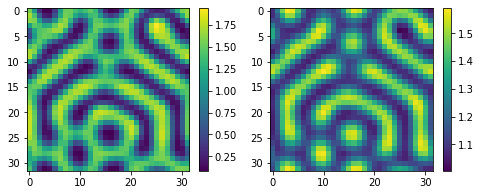

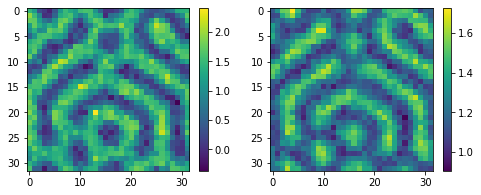

In [30]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obs_Y[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

In [3]:
model_params = {'training_data_size': T*32,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [95]:
layers = [3, 64, 64, 64, 64, 2]
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_lossKM = ASDM(dtype=tf.float64, D_a=.005, D_s=0.2, init_value=1.0)

modelKM = tu.TINN(pinnKM, 
                  pde_lossKM,                 
                  alpha = 0.5, 
                  print_precision=".8f")

In [96]:
results_KM = modelKM.train(epochs = 5000,
                          batch_size = 512,
                          X=obs_X,
                          Y=obs_Y,
                          X_pde=pde_X,
                          print_interval=10,
                          stop_threshold = 1e-5,
                          shuffle = True,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.34928414
total loss: 36.08644704, total regularisd loss: 36.08644704
obs u loss: 15.62783905, obs v loss: 8.43759332
pde u loss: 4.69201046, pde v loss: 7.32900421
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 0.86360 sigma_s: 0.89207 mu_a: 1.16931 rho_a: 0.84724 
rho_s: 1.04734 kappa_a: 1.03086 
Time taken: 20.67s

Start of epoch 10
Training observations acc over epoch: 0.15144277
total loss: 9.85081967, total regularisd loss: 34.78814960
obs u loss: 8.85756841, obs v loss: 0.83476840
pde u loss: 0.01748322, pde v loss: 0.14099964
lambda obs u: 3.91737000, lambda obs v: 0.08014923
lambda pde u: 0.00102983, lambda pde v: 0.00145094
sigma_a: 0.79715 sigma_s: 0.80411 mu_a: 1.26202 rho_a: 0.75045 
rho_s: 1.16681 kappa_a: 1.00076 
Time taken: 12.35s

Start of epoch 20
Training observations acc over epoch: 0.15183599
total loss: 9.89355316, total regularisd loss: 34.818


Start of epoch 190
Training observations acc over epoch: 0.15112044
total loss: 9.76814505, total regularisd loss: 35.02741920
obs u loss: 8.83699971, obs v loss: 0.83470784
pde u loss: 0.02218748, pde v loss: 0.07425003
lambda obs u: 3.94597745, lambda obs v: 0.05382650
lambda pde u: 0.00006349, lambda pde v: 0.00013256
sigma_a: 0.79700 sigma_s: 0.79771 mu_a: 1.26218 rho_a: 0.75027 
rho_s: 1.17544 kappa_a: 0.99590 
Time taken: 6.25s

Start of epoch 200
Training observations acc over epoch: 0.15134102
total loss: 9.79582490, total regularisd loss: 35.06390735
obs u loss: 8.84555951, obs v loss: 0.84026641
pde u loss: 0.02099687, pde v loss: 0.08900211
lambda obs u: 3.96401649, lambda obs v: 0.03579081
lambda pde u: 0.00004268, lambda pde v: 0.00015002
sigma_a: 0.79697 sigma_s: 0.79713 mu_a: 1.26222 rho_a: 0.75023 
rho_s: 1.17622 kappa_a: 0.99547 
Time taken: 6.21s

Start of epoch 210
Training observations acc over epoch: 0.15131095
total loss: 9.81227819, total regularisd loss: 35.070


Start of epoch 380
Training observations acc over epoch: 0.15103769
total loss: 9.70551266, total regularisd loss: 34.96307068
obs u loss: 8.83805066, obs v loss: 0.82836103
pde u loss: 0.02044810, pde v loss: 0.01865287
lambda obs u: 3.94714037, lambda obs v: 0.05277128
lambda pde u: 0.00005964, lambda pde v: 0.00002871
sigma_a: 0.79457 sigma_s: 0.78270 mu_a: 1.26484 rho_a: 0.74727 
rho_s: 1.19543 kappa_a: 0.98523 
Time taken: 6.25s

Start of epoch 390
Training observations acc over epoch: 0.15099640
total loss: 9.70607925, total regularisd loss: 34.98914677
obs u loss: 8.83490376, obs v loss: 0.82886655
pde u loss: 0.02195146, pde v loss: 0.02035749
lambda obs u: 3.95095838, lambda obs v: 0.04896784
lambda pde u: 0.00004951, lambda pde v: 0.00002427
sigma_a: 0.79439 sigma_s: 0.78213 mu_a: 1.26497 rho_a: 0.74710 
rho_s: 1.19619 kappa_a: 0.98483 
Time taken: 6.26s

Start of epoch 400
Training observations acc over epoch: 0.15206960
total loss: 9.80874854, total regularisd loss: 35.076


Start of epoch 570
Training observations acc over epoch: 0.14829156
total loss: 9.65222836, total regularisd loss: 34.21133511
obs u loss: 8.67564323, obs v loss: 0.81501689
pde u loss: 0.10269057, pde v loss: 0.05887768
lambda obs u: 3.93665052, lambda obs v: 0.06218238
lambda pde u: 0.00082899, lambda pde v: 0.00033812
sigma_a: 0.62643 sigma_s: 0.74522 mu_a: 1.14404 rho_a: 0.79429 
rho_s: 1.13311 kappa_a: 0.93490 
Time taken: 6.21s

Start of epoch 580
Training observations acc over epoch: 0.14821790
total loss: 9.65772537, total regularisd loss: 34.29183540
obs u loss: 8.67196823, obs v loss: 0.81397633
pde u loss: 0.10088508, pde v loss: 0.07089574
lambda obs u: 3.94471657, lambda obs v: 0.05410784
lambda pde u: 0.00083810, lambda pde v: 0.00033749
sigma_a: 0.57007 sigma_s: 0.74078 mu_a: 1.10047 rho_a: 0.80731 
rho_s: 1.10488 kappa_a: 0.90451 
Time taken: 6.22s

Start of epoch 590
Training observations acc over epoch: 0.14800501
total loss: 9.64220209, total regularisd loss: 34.238


Start of epoch 760
Training observations acc over epoch: 0.05222107
total loss: 3.35639445, total regularisd loss: 11.39463888
obs u loss: 2.97402134, obs v loss: 0.36812701
pde u loss: 0.00711201, pde v loss: 0.00713409
lambda obs u: 3.80355309, lambda obs v: 0.19083935
lambda pde u: 0.00182476, lambda pde v: 0.00378279
sigma_a: 0.00000 sigma_s: 0.02251 mu_a: 0.11643 rho_a: 0.21027 
rho_s: 0.04115 kappa_a: 1.02504 
Time taken: 6.26s

Start of epoch 770
Training observations acc over epoch: 0.04780285
total loss: 3.07100219, total regularisd loss: 10.34726246
obs u loss: 2.71074947, obs v loss: 0.34863312
pde u loss: 0.00467355, pde v loss: 0.00694605
lambda obs u: 3.80332224, lambda obs v: 0.19057316
lambda pde u: 0.00126430, lambda pde v: 0.00484031
sigma_a: 0.00000 sigma_s: 0.02256 mu_a: 0.09406 rho_a: 0.16964 
rho_s: 0.04014 kappa_a: 1.01278 
Time taken: 6.26s

Start of epoch 780
Training observations acc over epoch: 0.04343747
total loss: 2.79020678, total regularisd loss: 9.3607


Start of epoch 950
Training observations acc over epoch: 0.02549878
total loss: 1.63630234, total regularisd loss: 5.56599498
obs u loss: 1.45754607, obs v loss: 0.17437621
pde u loss: 0.00017719, pde v loss: 0.00420287
lambda obs u: 3.76922823, lambda obs v: 0.22475727
lambda pde u: 0.00002719, lambda pde v: 0.00598731
sigma_a: 0.00000 sigma_s: 0.02058 mu_a: 0.02048 rho_a: 0.03132 
rho_s: 0.03196 kappa_a: 0.70710 
Time taken: 6.28s

Start of epoch 960
Training observations acc over epoch: 0.02501984
total loss: 1.60556946, total regularisd loss: 5.47170678
obs u loss: 1.42948673, obs v loss: 0.17178303
pde u loss: 0.00015339, pde v loss: 0.00414631
lambda obs u: 3.78212295, lambda obs v: 0.21169139
lambda pde u: 0.00002304, lambda pde v: 0.00616262
sigma_a: 0.00000 sigma_s: 0.02075 mu_a: 0.01995 rho_a: 0.02958 
rho_s: 0.03049 kappa_a: 0.66753 
Time taken: 6.28s

Start of epoch 970
Training observations acc over epoch: 0.02570173
total loss: 1.64918597, total regularisd loss: 5.551582


Start of epoch 1140
Training observations acc over epoch: 0.02276728
total loss: 1.46096754, total regularisd loss: 4.90025870
obs u loss: 1.29130272, obs v loss: 0.16580312
pde u loss: 0.00004275, pde v loss: 0.00381895
lambda obs u: 3.78879972, lambda obs v: 0.20676253
lambda pde u: 0.00000340, lambda pde v: 0.00443435
sigma_a: 0.00103 sigma_s: 0.01846 mu_a: 0.01704 rho_a: 0.01702 
rho_s: 0.01945 kappa_a: 0.30480 
Time taken: 6.34s

Start of epoch 1150
Training observations acc over epoch: 0.02243965
total loss: 1.44000528, total regularisd loss: 4.84093433
obs u loss: 1.27786362, obs v loss: 0.15827395
pde u loss: 0.00004084, pde v loss: 0.00382687
lambda obs u: 3.76956291, lambda obs v: 0.22538635
lambda pde u: 0.00000345, lambda pde v: 0.00504729
sigma_a: 0.00099 sigma_s: 0.01813 mu_a: 0.01679 rho_a: 0.01675 
rho_s: 0.01968 kappa_a: 0.30295 
Time taken: 6.28s

Start of epoch 1160
Training observations acc over epoch: 0.02236811
total loss: 1.43540693, total regularisd loss: 4.866


Start of epoch 1330
Training observations acc over epoch: 0.02146751
total loss: 1.37783728, total regularisd loss: 4.64039829
obs u loss: 1.21886727, obs v loss: 0.15505336
pde u loss: 0.00003381, pde v loss: 0.00388285
lambda obs u: 3.78872913, lambda obs v: 0.20703430
lambda pde u: 0.00000287, lambda pde v: 0.00423370
sigma_a: 0.00045 sigma_s: 0.01829 mu_a: 0.01269 rho_a: 0.01291 
rho_s: 0.01888 kappa_a: 0.29544 
Time taken: 6.28s

Start of epoch 1340
Training observations acc over epoch: 0.02111857
total loss: 1.35549780, total regularisd loss: 4.57639428
obs u loss: 1.20188915, obs v loss: 0.14969947
pde u loss: 0.00003344, pde v loss: 0.00387574
lambda obs u: 3.74083936, lambda obs v: 0.25445141
lambda pde u: 0.00000348, lambda pde v: 0.00470576
sigma_a: 0.00042 sigma_s: 0.01838 mu_a: 0.01250 rho_a: 0.01273 
rho_s: 0.01897 kappa_a: 0.29494 
Time taken: 6.31s

Start of epoch 1350
Training observations acc over epoch: 0.02119744
total loss: 1.36057553, total regularisd loss: 4.527


Start of epoch 1520
Training observations acc over epoch: 0.02062620
total loss: 1.32416916, total regularisd loss: 4.43238320
obs u loss: 1.16796210, obs v loss: 0.15211437
pde u loss: 0.00003225, pde v loss: 0.00406044
lambda obs u: 3.78607427, lambda obs v: 0.20936118
lambda pde u: 0.00000281, lambda pde v: 0.00456174
sigma_a: 0.00000 sigma_s: 0.01770 mu_a: 0.00967 rho_a: 0.01023 
rho_s: 0.01925 kappa_a: 0.29969 
Time taken: 6.29s

Start of epoch 1530
Training observations acc over epoch: 0.02086534
total loss: 1.33951074, total regularisd loss: 4.49692907
obs u loss: 1.18363650, obs v loss: 0.15174515
pde u loss: 0.00003306, pde v loss: 0.00409603
lambda obs u: 3.77643311, lambda obs v: 0.21817511
lambda pde u: 0.00000333, lambda pde v: 0.00538846
sigma_a: 0.00000 sigma_s: 0.01808 mu_a: 0.00957 rho_a: 0.01015 
rho_s: 0.01935 kappa_a: 0.30035 
Time taken: 6.33s

Start of epoch 1540
Training observations acc over epoch: 0.02096685
total loss: 1.34601255, total regularisd loss: 4.509


Start of epoch 1710
Training observations acc over epoch: 0.02043083
total loss: 1.31192483, total regularisd loss: 4.41302627
obs u loss: 1.15677064, obs v loss: 0.15080268
pde u loss: 0.00003434, pde v loss: 0.00431717
lambda obs u: 3.77356858, lambda obs v: 0.22037490
lambda pde u: 0.00000345, lambda pde v: 0.00605308
sigma_a: 0.00000 sigma_s: 0.01843 mu_a: 0.00881 rho_a: 0.00940 
rho_s: 0.01929 kappa_a: 0.30285 
Time taken: 6.35s

Start of epoch 1720
Training observations acc over epoch: 0.02027899
total loss: 1.30223419, total regularisd loss: 4.36918313
obs u loss: 1.14825842, obs v loss: 0.14959682
pde u loss: 0.00003414, pde v loss: 0.00434481
lambda obs u: 3.76515298, lambda obs v: 0.22955032
lambda pde u: 0.00000360, lambda pde v: 0.00529310
sigma_a: 0.00000 sigma_s: 0.01785 mu_a: 0.00880 rho_a: 0.00940 
rho_s: 0.01942 kappa_a: 0.30373 
Time taken: 6.37s

Start of epoch 1730
Training observations acc over epoch: 0.02019970
total loss: 1.29719931, total regularisd loss: 4.326


Start of epoch 1900
Training observations acc over epoch: 0.01984921
total loss: 1.27500010, total regularisd loss: 4.26828572
obs u loss: 1.11859067, obs v loss: 0.15175919
pde u loss: 0.00003670, pde v loss: 0.00461354
lambda obs u: 3.78996271, lambda obs v: 0.20323757
lambda pde u: 0.00000333, lambda pde v: 0.00679639
sigma_a: 0.00000 sigma_s: 0.01826 mu_a: 0.00879 rho_a: 0.00933 
rho_s: 0.01914 kappa_a: 0.29684 
Time taken: 6.27s

Start of epoch 1910
Training observations acc over epoch: 0.01976988
total loss: 1.27004694, total regularisd loss: 4.23211891
obs u loss: 1.11542353, obs v loss: 0.14984890
pde u loss: 0.00003708, pde v loss: 0.00473742
lambda obs u: 3.75134899, lambda obs v: 0.24255202
lambda pde u: 0.00000403, lambda pde v: 0.00609496
sigma_a: 0.00000 sigma_s: 0.01868 mu_a: 0.00882 rho_a: 0.00931 
rho_s: 0.01893 kappa_a: 0.29554 
Time taken: 6.27s

Start of epoch 1920
Training observations acc over epoch: 0.01984620
total loss: 1.27500690, total regularisd loss: 4.239


Start of epoch 2090
Training observations acc over epoch: 0.01973003
total loss: 1.26790370, total regularisd loss: 4.23445629
obs u loss: 1.11082661, obs v loss: 0.15189496
pde u loss: 0.00004041, pde v loss: 0.00514172
lambda obs u: 3.75226865, lambda obs v: 0.24102933
lambda pde u: 0.00000476, lambda pde v: 0.00669726
sigma_a: 0.00000 sigma_s: 0.01823 mu_a: 0.00883 rho_a: 0.00922 
rho_s: 0.01855 kappa_a: 0.28766 
Time taken: 6.30s

Start of epoch 2100
Training observations acc over epoch: 0.01949489
total loss: 1.25283055, total regularisd loss: 4.14149695
obs u loss: 1.09347617, obs v loss: 0.15419647
pde u loss: 0.00004006, pde v loss: 0.00511785
lambda obs u: 3.76066485, lambda obs v: 0.23222305
lambda pde u: 0.00000470, lambda pde v: 0.00710741
sigma_a: 0.00000 sigma_s: 0.01799 mu_a: 0.00882 rho_a: 0.00923 
rho_s: 0.01840 kappa_a: 0.28692 
Time taken: 6.34s

Start of epoch 2110
Training observations acc over epoch: 0.01923583
total loss: 1.23629437, total regularisd loss: 4.092


Start of epoch 2280
Training observations acc over epoch: 0.01899672
total loss: 1.22144945, total regularisd loss: 4.00230452
obs u loss: 1.06241480, obs v loss: 0.15337499
pde u loss: 0.00004433, pde v loss: 0.00561534
lambda obs u: 3.74689959, lambda obs v: 0.24585077
lambda pde u: 0.00000588, lambda pde v: 0.00724376
sigma_a: 0.00000 sigma_s: 0.01850 mu_a: 0.00886 rho_a: 0.00916 
rho_s: 0.01870 kappa_a: 0.27919 
Time taken: 6.26s

Start of epoch 2290
Training observations acc over epoch: 0.01886637
total loss: 1.21306051, total regularisd loss: 4.01566508
obs u loss: 1.05618415, obs v loss: 0.15126365
pde u loss: 0.00004394, pde v loss: 0.00556877
lambda obs u: 3.76930458, lambda obs v: 0.22358073
lambda pde u: 0.00000496, lambda pde v: 0.00710973
sigma_a: 0.00000 sigma_s: 0.01795 mu_a: 0.00884 rho_a: 0.00919 
rho_s: 0.01891 kappa_a: 0.28017 
Time taken: 6.29s

Start of epoch 2300
Training observations acc over epoch: 0.01885941
total loss: 1.21266565, total regularisd loss: 3.999


Start of epoch 2470
Training observations acc over epoch: 0.01881125
total loss: 1.21014348, total regularisd loss: 3.97237724
obs u loss: 1.05018631, obs v loss: 0.15373352
pde u loss: 0.00004857, pde v loss: 0.00617507
lambda obs u: 3.76022033, lambda obs v: 0.23110106
lambda pde u: 0.00000615, lambda pde v: 0.00867245
sigma_a: 0.00000 sigma_s: 0.01790 mu_a: 0.00885 rho_a: 0.00910 
rho_s: 0.01866 kappa_a: 0.27292 
Time taken: 6.31s

Start of epoch 2480
Training observations acc over epoch: 0.01866039
total loss: 1.20041796, total regularisd loss: 3.93203653
obs u loss: 1.04147332, obs v loss: 0.15279197
pde u loss: 0.00004799, pde v loss: 0.00610467
lambda obs u: 3.76175790, lambda obs v: 0.22922622
lambda pde u: 0.00000666, lambda pde v: 0.00900922
sigma_a: 0.00000 sigma_s: 0.01811 mu_a: 0.00884 rho_a: 0.00910 
rho_s: 0.01881 kappa_a: 0.27310 
Time taken: 6.28s

Start of epoch 2490
Training observations acc over epoch: 0.01883526
total loss: 1.21166860, total regularisd loss: 3.978


Start of epoch 2660
Training observations acc over epoch: 0.01836509
total loss: 1.18210088, total regularisd loss: 3.88607427
obs u loss: 1.02298187, obs v loss: 0.15238408
pde u loss: 0.00005330, pde v loss: 0.00668164
lambda obs u: 3.74003303, lambda obs v: 0.25059064
lambda pde u: 0.00000653, lambda pde v: 0.00936980
sigma_a: 0.00000 sigma_s: 0.01910 mu_a: 0.00883 rho_a: 0.00906 
rho_s: 0.01870 kappa_a: 0.26780 
Time taken: 6.40s

Start of epoch 2670
Training observations acc over epoch: 0.01828997
total loss: 1.17731335, total regularisd loss: 3.87303201
obs u loss: 1.01792493, obs v loss: 0.15263327
pde u loss: 0.00005280, pde v loss: 0.00670235
lambda obs u: 3.75732898, lambda obs v: 0.23390169
lambda pde u: 0.00000710, lambda pde v: 0.00876224
sigma_a: 0.00000 sigma_s: 0.01882 mu_a: 0.00884 rho_a: 0.00903 
rho_s: 0.01827 kappa_a: 0.26850 
Time taken: 6.36s

Start of epoch 2680
Training observations acc over epoch: 0.01846845
total loss: 1.18874799, total regularisd loss: 3.884


Start of epoch 2850
Training observations acc over epoch: 0.01809522
total loss: 1.16553126, total regularisd loss: 3.78120535
obs u loss: 1.00510495, obs v loss: 0.15298900
pde u loss: 0.00005884, pde v loss: 0.00737847
lambda obs u: 3.72032717, lambda obs v: 0.26703899
lambda pde u: 0.00000951, lambda pde v: 0.01262433
sigma_a: 0.00000 sigma_s: 0.01839 mu_a: 0.00877 rho_a: 0.00890 
rho_s: 0.01843 kappa_a: 0.26029 
Time taken: 6.32s

Start of epoch 2860
Training observations acc over epoch: 0.01799859
total loss: 1.15930665, total regularisd loss: 3.73717028
obs u loss: 0.99852646, obs v loss: 0.15338343
pde u loss: 0.00005857, pde v loss: 0.00733819
lambda obs u: 3.71577081, lambda obs v: 0.27377510
lambda pde u: 0.00000805, lambda pde v: 0.01044605
sigma_a: 0.00000 sigma_s: 0.01881 mu_a: 0.00876 rho_a: 0.00892 
rho_s: 0.01880 kappa_a: 0.26096 
Time taken: 6.31s

Start of epoch 2870
Training observations acc over epoch: 0.01810869
total loss: 1.16650045, total regularisd loss: 3.790


Start of epoch 3040
Training observations acc over epoch: 0.01791420
total loss: 1.15464188, total regularisd loss: 3.72862206
obs u loss: 0.99068740, obs v loss: 0.15582128
pde u loss: 0.00006509, pde v loss: 0.00806810
lambda obs u: 3.72894265, lambda obs v: 0.25753958
lambda pde u: 0.00001024, lambda pde v: 0.01350752
sigma_a: 0.00001 sigma_s: 0.01868 mu_a: 0.00867 rho_a: 0.00884 
rho_s: 0.01900 kappa_a: 0.25469 
Time taken: 6.35s

Start of epoch 3050
Training observations acc over epoch: 0.01793142
total loss: 1.15590017, total regularisd loss: 3.70086837
obs u loss: 0.99153253, obs v loss: 0.15607834
pde u loss: 0.00006644, pde v loss: 0.00822287
lambda obs u: 3.70433281, lambda obs v: 0.27991282
lambda pde u: 0.00001057, lambda pde v: 0.01574380
sigma_a: 0.00000 sigma_s: 0.01934 mu_a: 0.00874 rho_a: 0.00876 
rho_s: 0.01865 kappa_a: 0.25295 
Time taken: 6.32s

Start of epoch 3060
Training observations acc over epoch: 0.01807461
total loss: 1.16509329, total regularisd loss: 3.719


Start of epoch 3230
Training observations acc over epoch: 0.01751415
total loss: 1.13004879, total regularisd loss: 3.63186761
obs u loss: 0.96690680, obs v loss: 0.15399891
pde u loss: 0.00007369, pde v loss: 0.00906938
lambda obs u: 3.67600559, lambda obs v: 0.30837271
lambda pde u: 0.00001362, lambda pde v: 0.01560808
sigma_a: 0.00000 sigma_s: 0.01875 mu_a: 0.00868 rho_a: 0.00869 
rho_s: 0.01907 kappa_a: 0.24790 
Time taken: 6.39s

Start of epoch 3240
Training observations acc over epoch: 0.01739436
total loss: 1.12240830, total regularisd loss: 3.56096210
obs u loss: 0.95832127, obs v loss: 0.15491770
pde u loss: 0.00007456, pde v loss: 0.00909478
lambda obs u: 3.68686763, lambda obs v: 0.30001814
lambda pde u: 0.00001196, lambda pde v: 0.01310227
sigma_a: 0.00000 sigma_s: 0.01871 mu_a: 0.00866 rho_a: 0.00869 
rho_s: 0.01899 kappa_a: 0.24875 
Time taken: 6.38s

Start of epoch 3250
Training observations acc over epoch: 0.01752092
total loss: 1.13050559, total regularisd loss: 3.610


Start of epoch 3420
Training observations acc over epoch: 0.01750865
total loss: 1.13059763, total regularisd loss: 3.61696160
obs u loss: 0.96324484, obs v loss: 0.15730850
pde u loss: 0.00008246, pde v loss: 0.00996184
lambda obs u: 3.70444520, lambda obs v: 0.27590852
lambda pde u: 0.00001809, lambda pde v: 0.01962819
sigma_a: 0.00000 sigma_s: 0.01844 mu_a: 0.00863 rho_a: 0.00868 
rho_s: 0.01873 kappa_a: 0.24746 
Time taken: 6.38s

Start of epoch 3430
Training observations acc over epoch: 0.01741576
total loss: 1.12479789, total regularisd loss: 3.59600088
obs u loss: 0.95743061, obs v loss: 0.15717807
pde u loss: 0.00008409, pde v loss: 0.01010511
lambda obs u: 3.71393260, lambda obs v: 0.26678642
lambda pde u: 0.00001733, lambda pde v: 0.01926365
sigma_a: 0.00000 sigma_s: 0.01849 mu_a: 0.00869 rho_a: 0.00864 
rho_s: 0.01896 kappa_a: 0.24760 
Time taken: 6.37s

Start of epoch 3440
Training observations acc over epoch: 0.01747302
total loss: 1.12848484, total regularisd loss: 3.609


Start of epoch 3610
Training observations acc over epoch: 0.01717675
total loss: 1.11026158, total regularisd loss: 3.52364165
obs u loss: 0.94115199, obs v loss: 0.15816032
pde u loss: 0.00009206, pde v loss: 0.01085721
lambda obs u: 3.70886624, lambda obs v: 0.27144860
lambda pde u: 0.00001824, lambda pde v: 0.01966692
sigma_a: 0.00000 sigma_s: 0.02049 mu_a: 0.00874 rho_a: 0.00872 
rho_s: 0.01874 kappa_a: 0.24810 
Time taken: 6.44s

Start of epoch 3620
Training observations acc over epoch: 0.01703932
total loss: 1.10163355, total regularisd loss: 3.47855203
obs u loss: 0.93488759, obs v loss: 0.15562853
pde u loss: 0.00009283, pde v loss: 0.01102460
lambda obs u: 3.66718679, lambda obs v: 0.31354755
lambda pde u: 0.00001780, lambda pde v: 0.01924786
sigma_a: 0.00000 sigma_s: 0.01915 mu_a: 0.00874 rho_a: 0.00874 
rho_s: 0.01991 kappa_a: 0.24776 
Time taken: 6.40s

Start of epoch 3630
Training observations acc over epoch: 0.01712947
total loss: 1.10745069, total regularisd loss: 3.496


Start of epoch 3800
Training observations acc over epoch: 0.01681101
total loss: 1.08786019, total regularisd loss: 3.43805604
obs u loss: 0.92015761, obs v loss: 0.15574678
pde u loss: 0.00010243, pde v loss: 0.01185336
lambda obs u: 3.68504789, lambda obs v: 0.29378519
lambda pde u: 0.00002049, lambda pde v: 0.02114644
sigma_a: 0.00000 sigma_s: 0.01962 mu_a: 0.00879 rho_a: 0.00878 
rho_s: 0.01940 kappa_a: 0.24854 
Time taken: 6.31s

Start of epoch 3810
Training observations acc over epoch: 0.01697513
total loss: 1.09849022, total regularisd loss: 3.45426081
obs u loss: 0.92832267, obs v loss: 0.15808541
pde u loss: 0.00010358, pde v loss: 0.01197857
lambda obs u: 3.68285424, lambda obs v: 0.29658321
lambda pde u: 0.00002085, lambda pde v: 0.02054170
sigma_a: 0.00000 sigma_s: 0.01994 mu_a: 0.00878 rho_a: 0.00878 
rho_s: 0.01946 kappa_a: 0.24803 
Time taken: 6.27s

Start of epoch 3820
Training observations acc over epoch: 0.01693456
total loss: 1.09585222, total regularisd loss: 3.465


Start of epoch 3990
Training observations acc over epoch: 0.01695378
total loss: 1.09815977, total regularisd loss: 3.40979233
obs u loss: 0.92298662, obs v loss: 0.16205555
pde u loss: 0.00011490, pde v loss: 0.01300270
lambda obs u: 3.68815726, lambda obs v: 0.28799880
lambda pde u: 0.00002090, lambda pde v: 0.02382305
sigma_a: 0.00000 sigma_s: 0.01910 mu_a: 0.00881 rho_a: 0.00870 
rho_s: 0.01899 kappa_a: 0.24371 
Time taken: 6.25s

Start of epoch 4000
Training observations acc over epoch: 0.01679383
total loss: 1.08824497, total regularisd loss: 3.45895433
obs u loss: 0.91799192, obs v loss: 0.15681285
pde u loss: 0.00011649, pde v loss: 0.01332371
lambda obs u: 3.68242257, lambda obs v: 0.29474725
lambda pde u: 0.00002233, lambda pde v: 0.02280786
sigma_a: 0.00000 sigma_s: 0.01933 mu_a: 0.00876 rho_a: 0.00872 
rho_s: 0.01943 kappa_a: 0.24401 
Time taken: 6.31s

Start of epoch 4010
Training observations acc over epoch: 0.01666056
total loss: 1.07957610, total regularisd loss: 3.382


Start of epoch 4180
Training observations acc over epoch: 0.01664688
total loss: 1.07972564, total regularisd loss: 3.36387837
obs u loss: 0.90775692, obs v loss: 0.15764324
pde u loss: 0.00012759, pde v loss: 0.01419789
lambda obs u: 3.64622441, lambda obs v: 0.32917634
lambda pde u: 0.00002858, lambda pde v: 0.02457067
sigma_a: 0.00000 sigma_s: 0.01948 mu_a: 0.00870 rho_a: 0.00875 
rho_s: 0.02005 kappa_a: 0.23991 
Time taken: 6.38s

Start of epoch 4190
Training observations acc over epoch: 0.01649196
total loss: 1.07008649, total regularisd loss: 3.35093061
obs u loss: 0.89798857, obs v loss: 0.15749674
pde u loss: 0.00012979, pde v loss: 0.01447140
lambda obs u: 3.66503900, lambda obs v: 0.30932713
lambda pde u: 0.00002611, lambda pde v: 0.02560776
sigma_a: 0.00000 sigma_s: 0.02168 mu_a: 0.00888 rho_a: 0.00857 
rho_s: 0.01918 kappa_a: 0.23847 
Time taken: 6.35s

Start of epoch 4200
Training observations acc over epoch: 0.01653473
total loss: 1.07290034, total regularisd loss: 3.340


Start of epoch 4370
Training observations acc over epoch: 0.01622341
total loss: 1.05423727, total regularisd loss: 3.24724100
obs u loss: 0.88339889, obs v loss: 0.15489954
pde u loss: 0.00014482, pde v loss: 0.01579402
lambda obs u: 3.60608440, lambda obs v: 0.36749686
lambda pde u: 0.00002992, lambda pde v: 0.02638882
sigma_a: 0.00000 sigma_s: 0.01977 mu_a: 0.00863 rho_a: 0.00853 
rho_s: 0.01942 kappa_a: 0.23088 
Time taken: 6.36s

Start of epoch 4380
Training observations acc over epoch: 0.01621089
total loss: 1.05306655, total regularisd loss: 3.26269297
obs u loss: 0.88132205, obs v loss: 0.15617515
pde u loss: 0.00014225, pde v loss: 0.01542710
lambda obs u: 3.64898387, lambda obs v: 0.32387493
lambda pde u: 0.00002875, lambda pde v: 0.02711245
sigma_a: 0.00000 sigma_s: 0.02019 mu_a: 0.00871 rho_a: 0.00843 
rho_s: 0.01829 kappa_a: 0.22892 
Time taken: 6.28s

Start of epoch 4390
Training observations acc over epoch: 0.01627870
total loss: 1.05795490, total regularisd loss: 3.277


Start of epoch 4560
Training observations acc over epoch: 0.01607098
total loss: 1.04552766, total regularisd loss: 3.22937306
obs u loss: 0.87178989, obs v loss: 0.15675296
pde u loss: 0.00015895, pde v loss: 0.01682586
lambda obs u: 3.64483764, lambda obs v: 0.32546668
lambda pde u: 0.00004191, lambda pde v: 0.02965376
sigma_a: 0.00000 sigma_s: 0.02059 mu_a: 0.00867 rho_a: 0.00843 
rho_s: 0.01964 kappa_a: 0.22407 
Time taken: 6.31s

Start of epoch 4570
Training observations acc over epoch: 0.01632909
total loss: 1.06228401, total regularisd loss: 3.27564404
obs u loss: 0.88729959, obs v loss: 0.15776213
pde u loss: 0.00016017, pde v loss: 0.01706212
lambda obs u: 3.64508972, lambda obs v: 0.32307738
lambda pde u: 0.00003666, lambda pde v: 0.03179624
sigma_a: 0.00000 sigma_s: 0.01987 mu_a: 0.00867 rho_a: 0.00837 
rho_s: 0.01968 kappa_a: 0.22530 
Time taken: 6.32s

Start of epoch 4580
Training observations acc over epoch: 0.01609908
total loss: 1.04762532, total regularisd loss: 3.212


Start of epoch 4750
Training observations acc over epoch: 0.01605823
total loss: 1.04626777, total regularisd loss: 3.20743657
obs u loss: 0.86987794, obs v loss: 0.15784870
pde u loss: 0.00017470, pde v loss: 0.01836643
lambda obs u: 3.61978077, lambda obs v: 0.34642525
lambda pde u: 0.00004615, lambda pde v: 0.03374783
sigma_a: 0.00000 sigma_s: 0.01965 mu_a: 0.00856 rho_a: 0.00835 
rho_s: 0.01989 kappa_a: 0.21661 
Time taken: 6.38s

Start of epoch 4760
Training observations acc over epoch: 0.01603217
total loss: 1.04477941, total regularisd loss: 3.20907673
obs u loss: 0.86682274, obs v loss: 0.15923598
pde u loss: 0.00017874, pde v loss: 0.01854195
lambda obs u: 3.65080050, lambda obs v: 0.31404836
lambda pde u: 0.00003726, lambda pde v: 0.03511388
sigma_a: 0.00000 sigma_s: 0.01953 mu_a: 0.00853 rho_a: 0.00833 
rho_s: 0.01923 kappa_a: 0.21675 
Time taken: 6.37s

Start of epoch 4770
Training observations acc over epoch: 0.01585140
total loss: 1.03298796, total regularisd loss: 3.189


Start of epoch 4940
Training observations acc over epoch: 0.01590032
total loss: 1.03836081, total regularisd loss: 3.17511269
obs u loss: 0.85911095, obs v loss: 0.15850921
pde u loss: 0.00019903, pde v loss: 0.02054162
lambda obs u: 3.63184159, lambda obs v: 0.32867442
lambda pde u: 0.00004317, lambda pde v: 0.03944082
sigma_a: 0.00000 sigma_s: 0.02086 mu_a: 0.00846 rho_a: 0.00835 
rho_s: 0.02049 kappa_a: 0.21061 
Time taken: 6.23s

Start of epoch 4950
Training observations acc over epoch: 0.01569206
total loss: 1.02465166, total regularisd loss: 3.11888256
obs u loss: 0.84589834, obs v loss: 0.15839370
pde u loss: 0.00019701, pde v loss: 0.02016261
lambda obs u: 3.64579330, lambda obs v: 0.31745469
lambda pde u: 0.00004208, lambda pde v: 0.03670993
sigma_a: 0.00000 sigma_s: 0.02086 mu_a: 0.00849 rho_a: 0.00824 
rho_s: 0.01889 kappa_a: 0.21285 
Time taken: 6.31s

Start of epoch 4960
Training observations acc over epoch: 0.01593480
total loss: 1.04003253, total regularisd loss: 3.190

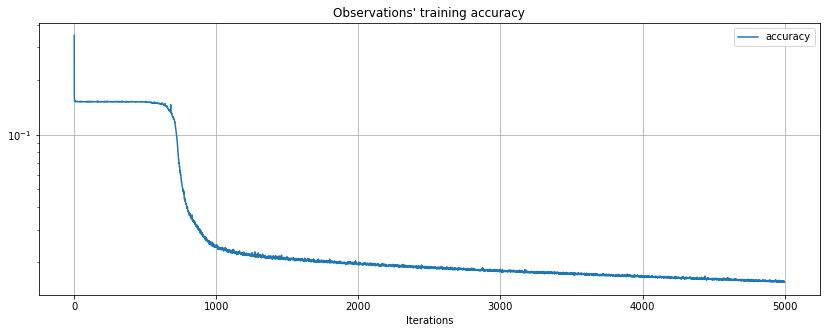

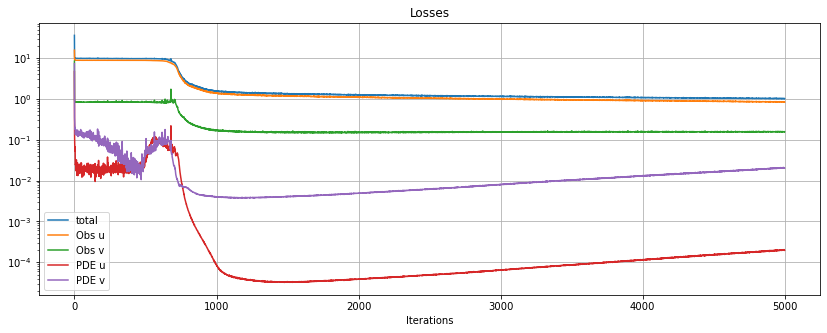

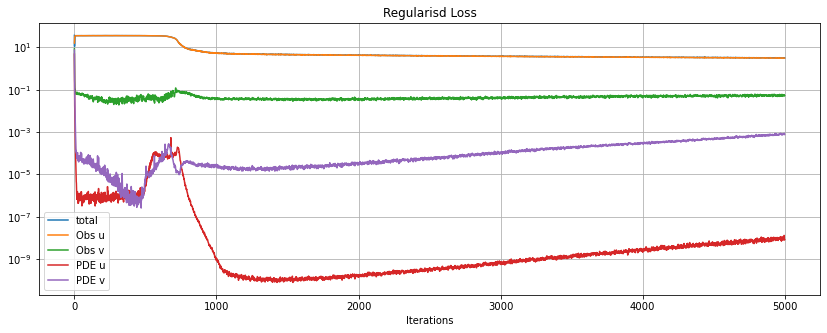

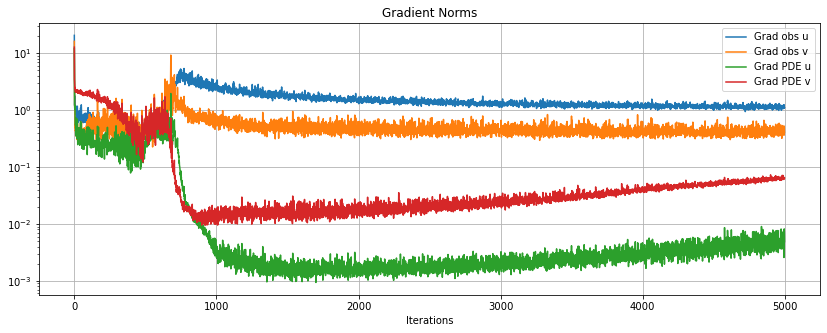

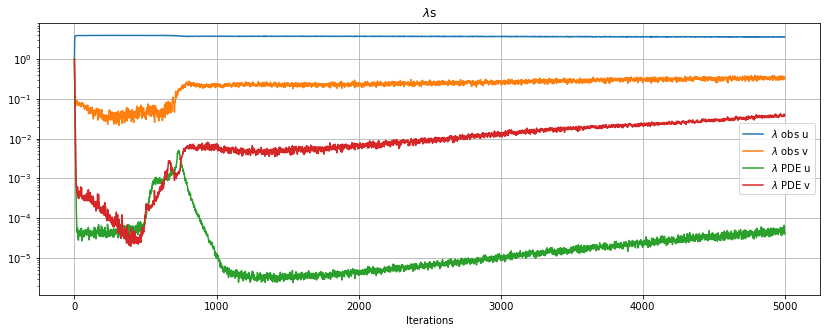

In [102]:
plot_result(merge_dict(results_KM))

In [16]:
import rdsolver

In [110]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (32, 32)
L = (50, 50)
t = t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = pde_lossKM.D_a.numpy()#0.01558*const1#0.005
D_s = pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
c0 = data[:, :, :, 0]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 512/512 [00:04<00:00, 113.07it/s]


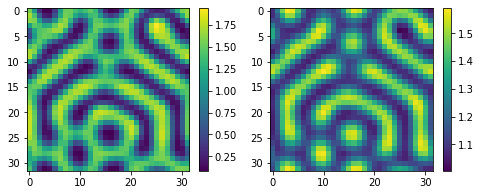

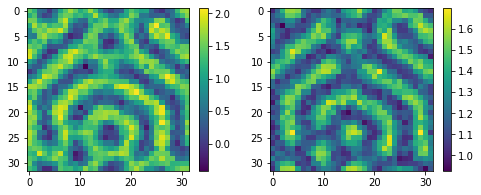

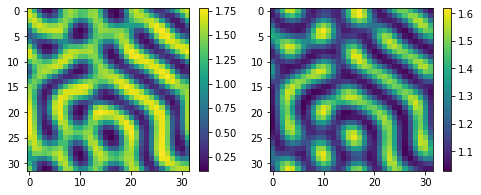

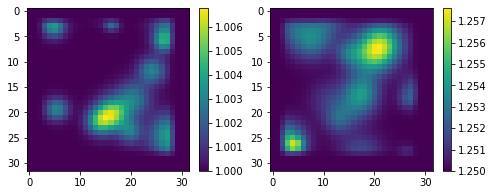

In [140]:
model_params_fig = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':False}
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

dataset_fig = create_dataset(data, t_star, N, T, L, **model_params_fig)
obs_Y_fig = dataset_fig['obs_output']

_ = plt.figure(figsize=(8,4))
plt.title("Original")
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("20% Noise")
plt.subplot(121)
plt.imshow(obs_Y_fig[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y_fig[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Initial condition")
plt.subplot(121)
plt.imshow(c[0, :,:,0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,0])
plt.colorbar(shrink=.75)
plt.show()

In [137]:
print(pde_lossKM.trainables_str())

sigma_a: 0.00000 sigma_s: 0.02089 mu_a: 0.00858 rho_a: 0.00819 
rho_s: 0.01939 kappa_a: 0.21088 


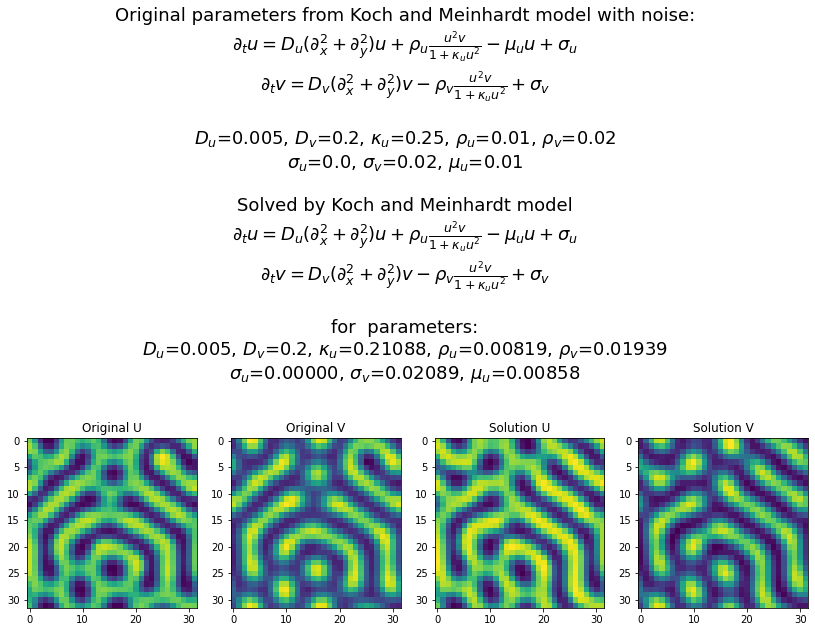

In [139]:
_ = plt.figure(figsize=(14,15))
# Direct solution
plt.suptitle(             "Original parameters from Koch and Meinhardt model with noise:\n"
             r"$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + \rho_u \frac{u^2 v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$"
             "\n"
             r"$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v - \rho_v \frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$"
             "\n"
             "\n"
             r"$D_u$=0.005, $D_v$=0.2, $\kappa_u$=0.25, $\rho_u$=0.01, $\rho_v$=0.02"
             "\n"
             r"$\sigma_u$=0.0, $\sigma_v$=0.02, $\mu_u$=0.01"
             "\n"
             "\n"
             "Solved by Koch and Meinhardt model\n"
             r"$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + \rho_u \frac{u^2 v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$"
             "\n"
             r"$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v - \rho_v \frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$"
             "\n"
             "\n"
             "for  parameters:\n"             
             r"$D_u$=0.005, $D_v$=0.2, $\kappa_u$=0.21088, $\rho_u$=0.00819, $\rho_v$=0.01939"
             "\n"
             r"$\sigma_u$=0.00000, $\sigma_v$=0.02089, $\mu_u$=0.00858"
             , fontsize=18)

plt.subplot(141)
plt.title("Original U")
plt.imshow(data[0, :,:,-1])
plt.subplot(142)
plt.title("Original V")
plt.imshow(data[1, :,:,-1])

plt.subplot(143)
plt.title("Solution U")
plt.imshow(c[0, :,:,-1])
plt.subplot(144)
plt.title("Solution V")
plt.imshow(c[1, :,:,-1])

plt.show()

In [ ]:
_ = plt.figure(figsize=(14,11))
# Direct solution
plt.suptitle(r"$L_{obs}=||\hat{u} - u||^2_2 + ||\hat{v} - v||^2_2$"
             "\n"
             "\n"
             "\n"
             r"$L_{res}=||u_t - D_u \nabla^2 u - f(u,v)||^2_2 + ||v_t - D_v \nabla^2 v - g(u,v)||^2_2$", fontsize=22)

plt.subplot(121)
plt.title("Solution U")
plt.imshow(c[0, :,:,-1])
plt.subplot(122)
plt.title("Solution V")
plt.imshow(c[1, :,:,-1])
plt.show()

# Second test: No fixed parameter but more data for training

In [6]:
1/8

0.125

In [7]:
model_params = {'training_data_size': (T*N)//(8),#T*32,
                'pde_data_size': (T*N)//(8),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':True}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [10]:
layers = [3, 64, 64, 64, 64, 2]
pinnKM_2 = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_lossKM_2 = ASDM(dtype=tf.float64, init_value=1.0)
non_zero_loss = Non_zero_params(pde_lossKM_2.name, parameters=[pde_lossKM_2.D_a, pde_lossKM_2.D_s])

modelKM_2 = tu.TINN(pinnKM_2, 
                  pde_lossKM_2,
                    extra_loss=[non_zero_loss],
                  alpha = 0.5, 
                  print_precision=".8f")

In [11]:
results_KM_2 = modelKM_2.train(epochs = 10000,
                          batch_size = 512,
                          X=obs_X,
                          Y=obs_Y,
                          X_pde=pde_X,
                          print_interval=10,
                          stop_threshold = 1.5e-3,
                          shuffle = True,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.31171221
total loss: 119.19382120, total regularisd loss: 119.19382120
obs u loss: 55.75389841, obs v loss: 24.04443043
pde u loss: 19.11895621, pde v loss: 20.27651180
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a: 1.11320 D_s: 1.08970 sigma_a: 0.91422 sigma_s: 0.93884 
mu_a: 1.12235 rho_a: 0.87406 rho_s: 1.10107 kappa_a: 1.02897 

extra loss non_zero_Loss_ASDM: 0.00002435
Time taken: 26.45s

Start of epoch 10
Training observations acc over epoch: 0.15278432
total loss: 40.00595691, total regularisd loss: 140.37298133
obs u loss: 35.53649929, obs v loss: 3.57629302
pde u loss: 0.20127467, pde v loss: 0.69186882
lambda obs u: 3.95025334, lambda obs v: 0.04688302
lambda pde u: 0.00120921, lambda pde v: 0.00165443
D_a: 1.20824 D_s: 1.21656 sigma_a: 0.80751 sigma_s: 0.84709 
mu_a: 1.24749 rho_a: 0.74031 rho_s: 1.26544 kappa_a: 1.00307 

extra loss non_zero_Loss_ASDM: 0.000

Training observations acc over epoch: 0.15103117
total loss: 38.87791356, total regularisd loss: 139.09256684
obs u loss: 35.31702837, obs v loss: 3.34694784
pde u loss: 0.13487593, pde v loss: 0.07905284
lambda obs u: 3.93894485, lambda obs v: 0.06089872
lambda pde u: 0.00012479, lambda pde v: 0.00003164
D_a: 2.98301 D_s: 2.99724 sigma_a: 0.76003 sigma_s: 0.82445 
mu_a: 1.23288 rho_a: 0.73710 rho_s: 1.27232 kappa_a: 0.96656 

extra loss non_zero_Loss_ASDM: 0.00000858
Time taken: 35.54s

Start of epoch 170
Training observations acc over epoch: 0.15095925
total loss: 38.86973661, total regularisd loss: 139.29660891
obs u loss: 35.30918842, obs v loss: 3.33638680
pde u loss: 0.13881385, pde v loss: 0.08533931
lambda obs u: 3.93558648, lambda obs v: 0.06425494
lambda pde u: 0.00012188, lambda pde v: 0.00003671
D_a: 3.11436 D_s: 3.11944 sigma_a: 0.73139 sigma_s: 0.82403 
mu_a: 1.21167 rho_a: 0.74551 rho_s: 1.25571 kappa_a: 0.94509 

extra loss non_zero_Loss_ASDM: 0.00000823
Time taken: 35.


Start of epoch 330
Training observations acc over epoch: 0.03839226
total loss: 9.87327250, total regularisd loss: 33.31007502
obs u loss: 8.75741630, obs v loss: 1.07100013
pde u loss: 0.02860682, pde v loss: 0.01603264
lambda obs u: 3.76206863, lambda obs v: 0.23280297
lambda pde u: 0.00284829, lambda pde v: 0.00228012
D_a: 0.08240 D_s: 0.20027 sigma_a: 0.00000 sigma_s: 0.01673 
mu_a: 0.08004 rho_a: 0.07478 rho_s: 0.01476 kappa_a: 0.18773 

extra loss non_zero_Loss_ASDM: 0.00021660
Time taken: 35.42s

Start of epoch 340
Training observations acc over epoch: 0.03244085
total loss: 8.34530213, total regularisd loss: 28.24682919
obs u loss: 7.43214230, obs v loss: 0.87271617
pde u loss: 0.02601066, pde v loss: 0.01420294
lambda obs u: 3.77556766, lambda obs v: 0.21901164
lambda pde u: 0.00309774, lambda pde v: 0.00232296
D_a: 0.07801 D_s: 0.19679 sigma_a: 0.00000 sigma_s: 0.01624 
mu_a: 0.08795 rho_a: 0.08478 rho_s: 0.01569 kappa_a: 0.20455 

extra loss non_zero_Loss_ASDM: 0.00023005
T


Start of epoch 500
Training observations acc over epoch: 0.02179884
total loss: 5.61644553, total regularisd loss: 18.88693299
obs u loss: 4.97580202, obs v loss: 0.60469921
pde u loss: 0.02370114, pde v loss: 0.01199312
lambda obs u: 3.78021622, lambda obs v: 0.21387802
lambda pde u: 0.00328171, lambda pde v: 0.00262404
D_a: 0.07170 D_s: 0.17335 sigma_a: 0.00000 sigma_s: 0.01707 
mu_a: 0.12102 rho_a: 0.11969 rho_s: 0.01519 kappa_a: 0.24941 

extra loss non_zero_Loss_ASDM: 0.00025005
Time taken: 25.36s

Start of epoch 510
Training observations acc over epoch: 0.02195277
total loss: 5.65765895, total regularisd loss: 19.02207661
obs u loss: 5.01807940, obs v loss: 0.60183065
pde u loss: 0.02400676, pde v loss: 0.01349904
lambda obs u: 3.75665769, lambda obs v: 0.23595339
lambda pde u: 0.00388061, lambda pde v: 0.00350831
D_a: 0.07498 D_s: 0.18783 sigma_a: 0.00000 sigma_s: 0.01688 
mu_a: 0.12149 rho_a: 0.12074 rho_s: 0.01663 kappa_a: 0.24753 

extra loss non_zero_Loss_ASDM: 0.00024311
T


Start of epoch 670
Training observations acc over epoch: 0.02137188
total loss: 5.51213903, total regularisd loss: 18.49447337
obs u loss: 4.86663956, obs v loss: 0.60455988
pde u loss: 0.02747841, pde v loss: 0.01321911
lambda obs u: 3.78737877, lambda obs v: 0.20665016
lambda pde u: 0.00327504, lambda pde v: 0.00269604
D_a: 0.07667 D_s: 0.17639 sigma_a: 0.00000 sigma_s: 0.01675 
mu_a: 0.13026 rho_a: 0.12908 rho_s: 0.01563 kappa_a: 0.25295 

extra loss non_zero_Loss_ASDM: 0.00024207
Time taken: 25.14s

Start of epoch 680
Training observations acc over epoch: 0.02121852
total loss: 5.46932071, total regularisd loss: 18.37131729
obs u loss: 4.83876619, obs v loss: 0.59317671
pde u loss: 0.02485642, pde v loss: 0.01226793
lambda obs u: 3.78113066, lambda obs v: 0.21303365
lambda pde u: 0.00315891, lambda pde v: 0.00267679
D_a: 0.07341 D_s: 0.16915 sigma_a: 0.00007 sigma_s: 0.01563 
mu_a: 0.12951 rho_a: 0.12832 rho_s: 0.01546 kappa_a: 0.25558 

extra loss non_zero_Loss_ASDM: 0.00025346
T


Start of epoch 840
Training observations acc over epoch: 0.02102848
total loss: 5.42558986, total regularisd loss: 18.29039991
obs u loss: 4.78783141, obs v loss: 0.59545987
pde u loss: 0.02749411, pde v loss: 0.01455728
lambda obs u: 3.79676279, lambda obs v: 0.19723482
lambda pde u: 0.00326827, lambda pde v: 0.00273411
D_a: 0.07296 D_s: 0.17538 sigma_a: 0.00055 sigma_s: 0.01746 
mu_a: 0.13158 rho_a: 0.13217 rho_s: 0.01635 kappa_a: 0.25417 

extra loss non_zero_Loss_ASDM: 0.00024719
Time taken: 35.75s

Start of epoch 850
Training observations acc over epoch: 0.02101496
total loss: 5.41896179, total regularisd loss: 18.26952193
obs u loss: 4.79111873, obs v loss: 0.58871097
pde u loss: 0.02615857, pde v loss: 0.01271837
lambda obs u: 3.76434201, lambda obs v: 0.22910564
lambda pde u: 0.00353680, lambda pde v: 0.00301555
D_a: 0.06989 D_s: 0.16348 sigma_a: 0.00111 sigma_s: 0.01537 
mu_a: 0.13123 rho_a: 0.13246 rho_s: 0.01632 kappa_a: 0.25556 

extra loss non_zero_Loss_ASDM: 0.00025515
T


Start of epoch 1010
Training observations acc over epoch: 0.02086855
total loss: 5.38351767, total regularisd loss: 18.19028191
obs u loss: 4.75086077, obs v loss: 0.59148938
pde u loss: 0.02726569, pde v loss: 0.01364385
lambda obs u: 3.79108443, lambda obs v: 0.20258379
lambda pde u: 0.00346385, lambda pde v: 0.00286794
D_a: 0.07044 D_s: 0.16388 sigma_a: 0.00000 sigma_s: 0.01613 
mu_a: 0.13116 rho_a: 0.13036 rho_s: 0.01589 kappa_a: 0.25648 

extra loss non_zero_Loss_ASDM: 0.00025799
Time taken: 35.46s

Start of epoch 1020
Training observations acc over epoch: 0.02069203
total loss: 5.33977958, total regularisd loss: 17.98175624
obs u loss: 4.70982933, obs v loss: 0.58733130
pde u loss: 0.02816761, pde v loss: 0.01419717
lambda obs u: 3.79065344, lambda obs v: 0.20370960
lambda pde u: 0.00310244, lambda pde v: 0.00253452
D_a: 0.06968 D_s: 0.16617 sigma_a: 0.00021 sigma_s: 0.01665 
mu_a: 0.13140 rho_a: 0.13181 rho_s: 0.01588 kappa_a: 0.25558 

extra loss non_zero_Loss_ASDM: 0.00025417


Start of epoch 1180
Training observations acc over epoch: 0.02052237
total loss: 5.29634134, total regularisd loss: 17.84393785
obs u loss: 4.66686788, obs v loss: 0.58685969
pde u loss: 0.02787544, pde v loss: 0.01447416
lambda obs u: 3.78819175, lambda obs v: 0.20540897
lambda pde u: 0.00348655, lambda pde v: 0.00291273
D_a: 0.07002 D_s: 0.16467 sigma_a: 0.00052 sigma_s: 0.01616 
mu_a: 0.12949 rho_a: 0.12987 rho_s: 0.01608 kappa_a: 0.25708 

extra loss non_zero_Loss_ASDM: 0.00026418
Time taken: 35.86s

Start of epoch 1190
Training observations acc over epoch: 0.02062650
total loss: 5.32252457, total regularisd loss: 17.87658839
obs u loss: 4.68534912, obs v loss: 0.59503325
pde u loss: 0.02780533, pde v loss: 0.01406799
lambda obs u: 3.80120863, lambda obs v: 0.19338561
lambda pde u: 0.00308653, lambda pde v: 0.00231923
D_a: 0.06837 D_s: 0.16009 sigma_a: 0.00139 sigma_s: 0.01417 
mu_a: 0.12875 rho_a: 0.12886 rho_s: 0.01629 kappa_a: 0.25886 

extra loss non_zero_Loss_ASDM: 0.00026888


Start of epoch 1350
Training observations acc over epoch: 0.02038518
total loss: 5.26224900, total regularisd loss: 17.72915521
obs u loss: 4.63165128, obs v loss: 0.58695429
pde u loss: 0.02876457, pde v loss: 0.01460655
lambda obs u: 3.79732216, lambda obs v: 0.19652620
lambda pde u: 0.00348220, lambda pde v: 0.00266944
D_a: 0.06777 D_s: 0.15856 sigma_a: 0.00000 sigma_s: 0.01557 
mu_a: 0.12692 rho_a: 0.12600 rho_s: 0.01493 kappa_a: 0.25907 

extra loss non_zero_Loss_ASDM: 0.00027231
Time taken: 25.36s

Start of epoch 1360
Training observations acc over epoch: 0.02046539
total loss: 5.28680169, total regularisd loss: 17.82485006
obs u loss: 4.64807177, obs v loss: 0.59106673
pde u loss: 0.03156749, pde v loss: 0.01583325
lambda obs u: 3.80984861, lambda obs v: 0.18427190
lambda pde u: 0.00322928, lambda pde v: 0.00265021
D_a: 0.06981 D_s: 0.16536 sigma_a: 0.00000 sigma_s: 0.01618 
mu_a: 0.12591 rho_a: 0.12693 rho_s: 0.01580 kappa_a: 0.25671 

extra loss non_zero_Loss_ASDM: 0.00026244


Start of epoch 1520
Training observations acc over epoch: 0.02038578
total loss: 5.26402543, total regularisd loss: 17.67168741
obs u loss: 4.62897112, obs v loss: 0.58978897
pde u loss: 0.02958624, pde v loss: 0.01539892
lambda obs u: 3.78701126, lambda obs v: 0.20668246
lambda pde u: 0.00340226, lambda pde v: 0.00290402
D_a: 0.06348 D_s: 0.15349 sigma_a: 0.00049 sigma_s: 0.01468 
mu_a: 0.12251 rho_a: 0.12339 rho_s: 0.01588 kappa_a: 0.26066 

extra loss non_zero_Loss_ASDM: 0.00028018
Time taken: 25.37s

Start of epoch 1530
Training observations acc over epoch: 0.02030827
total loss: 5.24477900, total regularisd loss: 17.64470738
obs u loss: 4.61416628, obs v loss: 0.58475110
pde u loss: 0.03050514, pde v loss: 0.01507816
lambda obs u: 3.77942522, lambda obs v: 0.21445969
lambda pde u: 0.00341730, lambda pde v: 0.00269779
D_a: 0.06518 D_s: 0.15295 sigma_a: 0.00001 sigma_s: 0.01460 
mu_a: 0.12274 rho_a: 0.12330 rho_s: 0.01558 kappa_a: 0.26000 

extra loss non_zero_Loss_ASDM: 0.00027832


Start of epoch 1690
Training observations acc over epoch: 0.02020964
total loss: 5.22296333, total regularisd loss: 17.53393532
obs u loss: 4.58521856, obs v loss: 0.58844919
pde u loss: 0.03265362, pde v loss: 0.01635900
lambda obs u: 3.80233553, lambda obs v: 0.19201783
lambda pde u: 0.00309293, lambda pde v: 0.00255371
D_a: 0.06293 D_s: 0.15143 sigma_a: 0.00104 sigma_s: 0.01419 
mu_a: 0.11823 rho_a: 0.12009 rho_s: 0.01636 kappa_a: 0.25986 

extra loss non_zero_Loss_ASDM: 0.00028297
Time taken: 25.40s

Start of epoch 1700
Training observations acc over epoch: 0.02018516
total loss: 5.21572231, total regularisd loss: 17.55893875
obs u loss: 4.57788440, obs v loss: 0.58951659
pde u loss: 0.03191651, pde v loss: 0.01611922
lambda obs u: 3.80405393, lambda obs v: 0.18988701
lambda pde u: 0.00336508, lambda pde v: 0.00269398
D_a: 0.06384 D_s: 0.15159 sigma_a: 0.00051 sigma_s: 0.01430 
mu_a: 0.11694 rho_a: 0.11922 rho_s: 0.01538 kappa_a: 0.25925 

extra loss non_zero_Loss_ASDM: 0.00028559


Start of epoch 1860
Training observations acc over epoch: 0.02017996
total loss: 5.21438568, total regularisd loss: 17.48897241
obs u loss: 4.57919490, obs v loss: 0.58687650
pde u loss: 0.03220377, pde v loss: 0.01581056
lambda obs u: 3.78867483, lambda obs v: 0.20547506
lambda pde u: 0.00322382, lambda pde v: 0.00262629
D_a: 0.06098 D_s: 0.14457 sigma_a: 0.00000 sigma_s: 0.01423 
mu_a: 0.11345 rho_a: 0.11440 rho_s: 0.01397 kappa_a: 0.25833 

extra loss non_zero_Loss_ASDM: 0.00029995
Time taken: 25.36s

Start of epoch 1870
Training observations acc over epoch: 0.02021440
total loss: 5.22299269, total regularisd loss: 17.52628376
obs u loss: 4.58071878, obs v loss: 0.59416864
pde u loss: 0.03212588, pde v loss: 0.01567743
lambda obs u: 3.80092998, lambda obs v: 0.19309835
lambda pde u: 0.00324597, lambda pde v: 0.00272571
D_a: 0.05965 D_s: 0.14393 sigma_a: 0.00146 sigma_s: 0.01325 
mu_a: 0.11175 rho_a: 0.11437 rho_s: 0.01430 kappa_a: 0.25876 

extra loss non_zero_Loss_ASDM: 0.00030197


Start of epoch 2030
Training observations acc over epoch: 0.01998495
total loss: 5.16492777, total regularisd loss: 17.30817433
obs u loss: 4.53416460, obs v loss: 0.58198126
pde u loss: 0.03220749, pde v loss: 0.01626484
lambda obs u: 3.77225716, lambda obs v: 0.22129783
lambda pde u: 0.00356178, lambda pde v: 0.00288322
D_a: 0.05720 D_s: 0.14206 sigma_a: 0.00053 sigma_s: 0.01344 
mu_a: 0.10877 rho_a: 0.10958 rho_s: 0.01411 kappa_a: 0.25487 

extra loss non_zero_Loss_ASDM: 0.00030958
Time taken: 25.43s

Start of epoch 2040
Training observations acc over epoch: 0.01997457
total loss: 5.16216223, total regularisd loss: 17.30033441
obs u loss: 4.52462803, obs v loss: 0.58886271
pde u loss: 0.03210700, pde v loss: 0.01625202
lambda obs u: 3.80383048, lambda obs v: 0.19003204
lambda pde u: 0.00342843, lambda pde v: 0.00270905
D_a: 0.05840 D_s: 0.14009 sigma_a: 0.00035 sigma_s: 0.01357 
mu_a: 0.10863 rho_a: 0.10832 rho_s: 0.01401 kappa_a: 0.25560 

extra loss non_zero_Loss_ASDM: 0.00031247


Start of epoch 2200
Training observations acc over epoch: 0.01996105
total loss: 5.16226121, total regularisd loss: 17.28423715
obs u loss: 4.52431734, obs v loss: 0.58571066
pde u loss: 0.03422842, pde v loss: 0.01769006
lambda obs u: 3.79183188, lambda obs v: 0.20166984
lambda pde u: 0.00355037, lambda pde v: 0.00294791
D_a: 0.05539 D_s: 0.13876 sigma_a: 0.00108 sigma_s: 0.01313 
mu_a: 0.10369 rho_a: 0.10541 rho_s: 0.01425 kappa_a: 0.25162 

extra loss non_zero_Loss_ASDM: 0.00031473
Time taken: 25.33s

Start of epoch 2210
Training observations acc over epoch: 0.01988470
total loss: 5.14027482, total regularisd loss: 17.19729896
obs u loss: 4.50689024, obs v loss: 0.58359475
pde u loss: 0.03320601, pde v loss: 0.01626077
lambda obs u: 3.78163963, lambda obs v: 0.21199696
lambda pde u: 0.00352458, lambda pde v: 0.00283883
D_a: 0.05878 D_s: 0.13684 sigma_a: 0.00055 sigma_s: 0.01307 
mu_a: 0.10350 rho_a: 0.10443 rho_s: 0.01270 kappa_a: 0.25165 

extra loss non_zero_Loss_ASDM: 0.00032305


Start of epoch 2370
Training observations acc over epoch: 0.01992550
total loss: 5.15292970, total regularisd loss: 17.22274254
obs u loss: 4.51390782, obs v loss: 0.58702076
pde u loss: 0.03432957, pde v loss: 0.01734163
lambda obs u: 3.78037527, lambda obs v: 0.21314861
lambda pde u: 0.00352885, lambda pde v: 0.00294726
D_a: 0.05424 D_s: 0.13524 sigma_a: 0.00050 sigma_s: 0.01307 
mu_a: 0.10006 rho_a: 0.10059 rho_s: 0.01324 kappa_a: 0.24992 

extra loss non_zero_Loss_ASDM: 0.00032992
Time taken: 25.34s

Start of epoch 2380
Training observations acc over epoch: 0.01997263
total loss: 5.16501684, total regularisd loss: 17.20842402
obs u loss: 4.52349407, obs v loss: 0.58949859
pde u loss: 0.03432528, pde v loss: 0.01736723
lambda obs u: 3.78018380, lambda obs v: 0.21342878
lambda pde u: 0.00354396, lambda pde v: 0.00284346
D_a: 0.05389 D_s: 0.13381 sigma_a: 0.00004 sigma_s: 0.01339 
mu_a: 0.10029 rho_a: 0.10094 rho_s: 0.01373 kappa_a: 0.24882 

extra loss non_zero_Loss_ASDM: 0.00033167


Start of epoch 2540
Training observations acc over epoch: 0.01986753
total loss: 5.13731442, total regularisd loss: 17.17811392
obs u loss: 4.49537817, obs v loss: 0.59071074
pde u loss: 0.03432907, pde v loss: 0.01655094
lambda obs u: 3.79493150, lambda obs v: 0.19847111
lambda pde u: 0.00358394, lambda pde v: 0.00301345
D_a: 0.05241 D_s: 0.13000 sigma_a: 0.00133 sigma_s: 0.01144 
mu_a: 0.09641 rho_a: 0.09713 rho_s: 0.01287 kappa_a: 0.24779 

extra loss non_zero_Loss_ASDM: 0.00034551
Time taken: 25.36s

Start of epoch 2550
Training observations acc over epoch: 0.01987722
total loss: 5.14255862, total regularisd loss: 17.24142804
obs u loss: 4.49724346, obs v loss: 0.59132416
pde u loss: 0.03594834, pde v loss: 0.01770532
lambda obs u: 3.80378839, lambda obs v: 0.18979380
lambda pde u: 0.00356268, lambda pde v: 0.00285513
D_a: 0.05508 D_s: 0.13302 sigma_a: 0.00011 sigma_s: 0.01246 
mu_a: 0.09746 rho_a: 0.09674 rho_s: 0.01244 kappa_a: 0.24717 

extra loss non_zero_Loss_ASDM: 0.00033735


Start of epoch 2710
Training observations acc over epoch: 0.01979656
total loss: 5.12102214, total regularisd loss: 17.07568281
obs u loss: 4.47447422, obs v loss: 0.59344863
pde u loss: 0.03549316, pde v loss: 0.01725180
lambda obs u: 3.79467109, lambda obs v: 0.19914624
lambda pde u: 0.00343163, lambda pde v: 0.00275103
D_a: 0.05163 D_s: 0.12301 sigma_a: 0.00029 sigma_s: 0.01195 
mu_a: 0.09419 rho_a: 0.09337 rho_s: 0.01249 kappa_a: 0.24641 

extra loss non_zero_Loss_ASDM: 0.00035434
Time taken: 25.09s

Start of epoch 2720
Training observations acc over epoch: 0.01980815
total loss: 5.12379953, total regularisd loss: 17.07676250
obs u loss: 4.47728356, obs v loss: 0.59360290
pde u loss: 0.03532981, pde v loss: 0.01722903
lambda obs u: 3.78910053, lambda obs v: 0.20444718
lambda pde u: 0.00355809, lambda pde v: 0.00289421
D_a: 0.05181 D_s: 0.12516 sigma_a: 0.00000 sigma_s: 0.01309 
mu_a: 0.09391 rho_a: 0.09318 rho_s: 0.01170 kappa_a: 0.24566 

extra loss non_zero_Loss_ASDM: 0.00035424


Start of epoch 2880
Training observations acc over epoch: 0.01980005
total loss: 5.12360466, total regularisd loss: 17.02109475
obs u loss: 4.47442514, obs v loss: 0.59438745
pde u loss: 0.03643521, pde v loss: 0.01799408
lambda obs u: 3.77736646, lambda obs v: 0.21628162
lambda pde u: 0.00355495, lambda pde v: 0.00279696
D_a: 0.05183 D_s: 0.12211 sigma_a: 0.00039 sigma_s: 0.01160 
mu_a: 0.09090 rho_a: 0.09050 rho_s: 0.01257 kappa_a: 0.24224 

extra loss non_zero_Loss_ASDM: 0.00036278
Time taken: 25.21s

Start of epoch 2890
Training observations acc over epoch: 0.01982395
total loss: 5.13068495, total regularisd loss: 17.00706671
obs u loss: 4.47797793, obs v loss: 0.59695326
pde u loss: 0.03696672, pde v loss: 0.01842710
lambda obs u: 3.77778951, lambda obs v: 0.21551753
lambda pde u: 0.00368700, lambda pde v: 0.00300596
D_a: 0.05146 D_s: 0.12385 sigma_a: 0.00175 sigma_s: 0.01119 
mu_a: 0.08969 rho_a: 0.09073 rho_s: 0.01284 kappa_a: 0.24157 

extra loss non_zero_Loss_ASDM: 0.00035993


Start of epoch 3050
Training observations acc over epoch: 0.01969373
total loss: 5.09810512, total regularisd loss: 16.95236484
obs u loss: 4.44474842, obs v loss: 0.59684768
pde u loss: 0.03732346, pde v loss: 0.01881526
lambda obs u: 3.78487898, lambda obs v: 0.20843927
lambda pde u: 0.00366460, lambda pde v: 0.00301715
D_a: 0.04935 D_s: 0.12232 sigma_a: 0.00000 sigma_s: 0.01236 
mu_a: 0.08836 rho_a: 0.08700 rho_s: 0.01191 kappa_a: 0.24017 

extra loss non_zero_Loss_ASDM: 0.00037031
Time taken: 25.48s

Start of epoch 3060
Training observations acc over epoch: 0.01970135
total loss: 5.09840251, total regularisd loss: 16.93341792
obs u loss: 4.44625490, obs v loss: 0.59729026
pde u loss: 0.03616037, pde v loss: 0.01831996
lambda obs u: 3.77941794, lambda obs v: 0.21392862
lambda pde u: 0.00363973, lambda pde v: 0.00301370
D_a: 0.04756 D_s: 0.11682 sigma_a: 0.00000 sigma_s: 0.01236 
mu_a: 0.08829 rho_a: 0.08562 rho_s: 0.01105 kappa_a: 0.24196 

extra loss non_zero_Loss_ASDM: 0.00037702


Start of epoch 3220
Training observations acc over epoch: 0.01967020
total loss: 5.09321632, total regularisd loss: 16.88349209
obs u loss: 4.43902085, obs v loss: 0.59655226
pde u loss: 0.03802663, pde v loss: 0.01923187
lambda obs u: 3.77197689, lambda obs v: 0.22132888
lambda pde u: 0.00368137, lambda pde v: 0.00301286
D_a: 0.04630 D_s: 0.11744 sigma_a: 0.00000 sigma_s: 0.01143 
mu_a: 0.08392 rho_a: 0.08369 rho_s: 0.01153 kappa_a: 0.23769 

extra loss non_zero_Loss_ASDM: 0.00038472
Time taken: 25.81s

Start of epoch 3230
Training observations acc over epoch: 0.01961027
total loss: 5.07887747, total regularisd loss: 16.85199826
obs u loss: 4.42656558, obs v loss: 0.59366648
pde u loss: 0.03863798, pde v loss: 0.01962640
lambda obs u: 3.77770792, lambda obs v: 0.21573347
lambda pde u: 0.00363426, lambda pde v: 0.00292434
D_a: 0.04617 D_s: 0.11532 sigma_a: 0.00018 sigma_s: 0.01205 
mu_a: 0.08424 rho_a: 0.08363 rho_s: 0.01132 kappa_a: 0.23804 

extra loss non_zero_Loss_ASDM: 0.00038104


Start of epoch 3390
Training observations acc over epoch: 0.01968307
total loss: 5.09850513, total regularisd loss: 16.89367408
obs u loss: 4.43265327, obs v loss: 0.60621387
pde u loss: 0.03950425, pde v loss: 0.01973947
lambda obs u: 3.79411030, lambda obs v: 0.19918641
lambda pde u: 0.00369082, lambda pde v: 0.00301247
D_a: 0.04549 D_s: 0.11285 sigma_a: 0.00076 sigma_s: 0.01052 
mu_a: 0.08082 rho_a: 0.08040 rho_s: 0.01086 kappa_a: 0.23678 

extra loss non_zero_Loss_ASDM: 0.00039428
Time taken: 26.06s

Start of epoch 3400
Training observations acc over epoch: 0.01961718
total loss: 5.08118793, total regularisd loss: 16.88054961
obs u loss: 4.42432002, obs v loss: 0.59767912
pde u loss: 0.03927759, pde v loss: 0.01951306
lambda obs u: 3.77685760, lambda obs v: 0.21671311
lambda pde u: 0.00355323, lambda pde v: 0.00287606
D_a: 0.04406 D_s: 0.10986 sigma_a: 0.00000 sigma_s: 0.01120 
mu_a: 0.08204 rho_a: 0.08078 rho_s: 0.01109 kappa_a: 0.23719 

extra loss non_zero_Loss_ASDM: 0.00039813


Start of epoch 3560
Training observations acc over epoch: 0.01953975
total loss: 5.06435914, total regularisd loss: 16.75677048
obs u loss: 4.40169808, obs v loss: 0.60047710
pde u loss: 0.04113797, pde v loss: 0.02064164
lambda obs u: 3.78142676, lambda obs v: 0.21212591
lambda pde u: 0.00355706, lambda pde v: 0.00289027
D_a: 0.04414 D_s: 0.11000 sigma_a: 0.00000 sigma_s: 0.01119 
mu_a: 0.07992 rho_a: 0.07712 rho_s: 0.01071 kappa_a: 0.23662 

extra loss non_zero_Loss_ASDM: 0.00040435
Time taken: 27.24s

Start of epoch 3570
Training observations acc over epoch: 0.01953995
total loss: 5.06393663, total regularisd loss: 16.78730531
obs u loss: 4.40277603, obs v loss: 0.59945067
pde u loss: 0.04081622, pde v loss: 0.02048820
lambda obs u: 3.77741100, lambda obs v: 0.21608282
lambda pde u: 0.00357828, lambda pde v: 0.00292790
D_a: 0.04524 D_s: 0.11059 sigma_a: 0.00001 sigma_s: 0.01080 
mu_a: 0.07931 rho_a: 0.07785 rho_s: 0.01131 kappa_a: 0.23506 

extra loss non_zero_Loss_ASDM: 0.00040551


Start of epoch 3730
Training observations acc over epoch: 0.01952486
total loss: 5.06055913, total regularisd loss: 16.76361627
obs u loss: 4.39698146, obs v loss: 0.60138232
pde u loss: 0.04113008, pde v loss: 0.02063967
lambda obs u: 3.78257683, lambda obs v: 0.21087058
lambda pde u: 0.00357938, lambda pde v: 0.00297322
D_a: 0.04336 D_s: 0.10205 sigma_a: 0.00000 sigma_s: 0.01027 
mu_a: 0.07607 rho_a: 0.07509 rho_s: 0.01004 kappa_a: 0.23743 

extra loss non_zero_Loss_ASDM: 0.00042561
Time taken: 26.37s

Start of epoch 3740
Training observations acc over epoch: 0.01958580
total loss: 5.07790251, total regularisd loss: 16.75047521
obs u loss: 4.41055383, obs v loss: 0.60341037
pde u loss: 0.04233344, pde v loss: 0.02118490
lambda obs u: 3.75962253, lambda obs v: 0.23376016
lambda pde u: 0.00370187, lambda pde v: 0.00291544
D_a: 0.04219 D_s: 0.10708 sigma_a: 0.00000 sigma_s: 0.01072 
mu_a: 0.07556 rho_a: 0.07537 rho_s: 0.01047 kappa_a: 0.23648 

extra loss non_zero_Loss_ASDM: 0.00041997


Start of epoch 3900
Training observations acc over epoch: 0.01946631
total loss: 5.04919315, total regularisd loss: 16.64893345
obs u loss: 4.37730949, obs v loss: 0.60606593
pde u loss: 0.04339886, pde v loss: 0.02199105
lambda obs u: 3.77915994, lambda obs v: 0.21437824
lambda pde u: 0.00356058, lambda pde v: 0.00290124
D_a: 0.04307 D_s: 0.10748 sigma_a: 0.00000 sigma_s: 0.01037 
mu_a: 0.07425 rho_a: 0.07388 rho_s: 0.01048 kappa_a: 0.23597 

extra loss non_zero_Loss_ASDM: 0.00042781
Time taken: 26.40s

Start of epoch 3910
Training observations acc over epoch: 0.01950894
total loss: 5.05841562, total regularisd loss: 16.69342107
obs u loss: 4.38637908, obs v loss: 0.60790792
pde u loss: 0.04233042, pde v loss: 0.02136367
lambda obs u: 3.78126718, lambda obs v: 0.21218398
lambda pde u: 0.00363015, lambda pde v: 0.00291870
D_a: 0.04036 D_s: 0.10228 sigma_a: 0.00044 sigma_s: 0.00984 
mu_a: 0.07359 rho_a: 0.07410 rho_s: 0.01055 kappa_a: 0.23655 

extra loss non_zero_Loss_ASDM: 0.00043454


Start of epoch 4070
Training observations acc over epoch: 0.01950888
total loss: 5.06245923, total regularisd loss: 16.67560183
obs u loss: 4.38639696, obs v loss: 0.60787527
pde u loss: 0.04484383, pde v loss: 0.02290219
lambda obs u: 3.76090324, lambda obs v: 0.23256492
lambda pde u: 0.00364961, lambda pde v: 0.00288224
D_a: 0.03973 D_s: 0.09942 sigma_a: 0.00000 sigma_s: 0.01063 
mu_a: 0.07268 rho_a: 0.07190 rho_s: 0.01088 kappa_a: 0.23695 

extra loss non_zero_Loss_ASDM: 0.00044098
Time taken: 26.61s

Start of epoch 4080
Training observations acc over epoch: 0.01947833
total loss: 5.05355135, total regularisd loss: 16.64152232
obs u loss: 4.37958995, obs v loss: 0.60686183
pde u loss: 0.04439559, pde v loss: 0.02225940
lambda obs u: 3.76488559, lambda obs v: 0.22872495
lambda pde u: 0.00356513, lambda pde v: 0.00282433
D_a: 0.03864 D_s: 0.09703 sigma_a: 0.00000 sigma_s: 0.01001 
mu_a: 0.07295 rho_a: 0.07194 rho_s: 0.00994 kappa_a: 0.23646 

extra loss non_zero_Loss_ASDM: 0.00044459


Start of epoch 4240
Training observations acc over epoch: 0.01940708
total loss: 5.03818996, total regularisd loss: 16.55697388
obs u loss: 4.35848305, obs v loss: 0.60972990
pde u loss: 0.04583840, pde v loss: 0.02368595
lambda obs u: 3.77857503, lambda obs v: 0.21530543
lambda pde u: 0.00343787, lambda pde v: 0.00268167
D_a: 0.03893 D_s: 0.09543 sigma_a: 0.00056 sigma_s: 0.00988 
mu_a: 0.07107 rho_a: 0.07098 rho_s: 0.01008 kappa_a: 0.23570 

extra loss non_zero_Loss_ASDM: 0.00045265
Time taken: 26.93s

Start of epoch 4250
Training observations acc over epoch: 0.01939857
total loss: 5.03470144, total regularisd loss: 16.51792699
obs u loss: 4.35990518, obs v loss: 0.60612898
pde u loss: 0.04522843, pde v loss: 0.02297651
lambda obs u: 3.75495829, lambda obs v: 0.23855892
lambda pde u: 0.00361520, lambda pde v: 0.00286760
D_a: 0.04099 D_s: 0.09733 sigma_a: 0.00000 sigma_s: 0.00982 
mu_a: 0.07082 rho_a: 0.06933 rho_s: 0.00978 kappa_a: 0.23851 

extra loss non_zero_Loss_ASDM: 0.00046234


Start of epoch 4410
Training observations acc over epoch: 0.01934664
total loss: 5.02505696, total regularisd loss: 16.47019987
obs u loss: 4.34414238, obs v loss: 0.60859819
pde u loss: 0.04746376, pde v loss: 0.02438620
lambda obs u: 3.76095039, lambda obs v: 0.23282616
lambda pde u: 0.00348706, lambda pde v: 0.00273640
D_a: 0.03953 D_s: 0.09678 sigma_a: 0.00002 sigma_s: 0.00982 
mu_a: 0.06945 rho_a: 0.06840 rho_s: 0.00956 kappa_a: 0.23694 

extra loss non_zero_Loss_ASDM: 0.00046643
Time taken: 26.38s

Start of epoch 4420
Training observations acc over epoch: 0.01933726
total loss: 5.02336087, total regularisd loss: 16.46814930
obs u loss: 4.34183932, obs v loss: 0.60849590
pde u loss: 0.04757437, pde v loss: 0.02498510
lambda obs u: 3.76376796, lambda obs v: 0.23014715
lambda pde u: 0.00346452, lambda pde v: 0.00262037
D_a: 0.03781 D_s: 0.09377 sigma_a: 0.00000 sigma_s: 0.01018 
mu_a: 0.06916 rho_a: 0.06872 rho_s: 0.01007 kappa_a: 0.23390 

extra loss non_zero_Loss_ASDM: 0.00046618


Start of epoch 4580
Training observations acc over epoch: 0.01931588
total loss: 5.02073639, total regularisd loss: 16.44979983
obs u loss: 4.33550700, obs v loss: 0.60935848
pde u loss: 0.04948648, pde v loss: 0.02590937
lambda obs u: 3.76809489, lambda obs v: 0.22589988
lambda pde u: 0.00344172, lambda pde v: 0.00256351
D_a: 0.03856 D_s: 0.09627 sigma_a: 0.00008 sigma_s: 0.00908 
mu_a: 0.06684 rho_a: 0.06752 rho_s: 0.00923 kappa_a: 0.23415 

extra loss non_zero_Loss_ASDM: 0.00047506
Time taken: 26.56s

Start of epoch 4590
Training observations acc over epoch: 0.01929804
total loss: 5.01476711, total regularisd loss: 16.45220049
obs u loss: 4.33010359, obs v loss: 0.61019543
pde u loss: 0.04877314, pde v loss: 0.02521374
lambda obs u: 3.76234083, lambda obs v: 0.23142610
lambda pde u: 0.00349105, lambda pde v: 0.00274202
D_a: 0.03551 D_s: 0.09374 sigma_a: 0.00000 sigma_s: 0.01011 
mu_a: 0.06741 rho_a: 0.06629 rho_s: 0.00960 kappa_a: 0.23471 

extra loss non_zero_Loss_ASDM: 0.00048121


Start of epoch 4750
Training observations acc over epoch: 0.01931579
total loss: 5.02247009, total regularisd loss: 16.37734912
obs u loss: 4.33182850, obs v loss: 0.61301458
pde u loss: 0.05024697, pde v loss: 0.02689054
lambda obs u: 3.75705785, lambda obs v: 0.23685440
lambda pde u: 0.00344249, lambda pde v: 0.00264526
D_a: 0.03679 D_s: 0.09442 sigma_a: 0.00000 sigma_s: 0.01038 
mu_a: 0.06600 rho_a: 0.06461 rho_s: 0.00980 kappa_a: 0.23228 

extra loss non_zero_Loss_ASDM: 0.00048949
Time taken: 27.01s

Start of epoch 4760
Training observations acc over epoch: 0.01935719
total loss: 5.03269450, total regularisd loss: 16.41171513
obs u loss: 4.33801544, obs v loss: 0.61742637
pde u loss: 0.05058355, pde v loss: 0.02617497
lambda obs u: 3.76334558, lambda obs v: 0.23057428
lambda pde u: 0.00347996, lambda pde v: 0.00260018
D_a: 0.03423 D_s: 0.08949 sigma_a: 0.00028 sigma_s: 0.00904 
mu_a: 0.06447 rho_a: 0.06513 rho_s: 0.01036 kappa_a: 0.23285 

extra loss non_zero_Loss_ASDM: 0.00049417


Start of epoch 4920
Training observations acc over epoch: 0.01928260
total loss: 5.01781148, total regularisd loss: 16.38445911
obs u loss: 4.32185733, obs v loss: 0.61448854
pde u loss: 0.05277232, pde v loss: 0.02819287
lambda obs u: 3.76345269, lambda obs v: 0.23073919
lambda pde u: 0.00337099, lambda pde v: 0.00243714
D_a: 0.03500 D_s: 0.08845 sigma_a: 0.00010 sigma_s: 0.00973 
mu_a: 0.06415 rho_a: 0.06224 rho_s: 0.00912 kappa_a: 0.23213 

extra loss non_zero_Loss_ASDM: 0.00050042
Time taken: 26.12s

Start of epoch 4930
Training observations acc over epoch: 0.01929326
total loss: 5.01801063, total regularisd loss: 16.40755353
obs u loss: 4.32379746, obs v loss: 0.61527521
pde u loss: 0.05158247, pde v loss: 0.02684492
lambda obs u: 3.76950687, lambda obs v: 0.22424343
lambda pde u: 0.00351375, lambda pde v: 0.00273595
D_a: 0.03696 D_s: 0.08879 sigma_a: 0.00009 sigma_s: 0.00911 
mu_a: 0.06357 rho_a: 0.06189 rho_s: 0.00919 kappa_a: 0.23312 

extra loss non_zero_Loss_ASDM: 0.00051056


Start of epoch 5090
Training observations acc over epoch: 0.01926293
total loss: 5.01623161, total regularisd loss: 16.33569810
obs u loss: 4.31802455, obs v loss: 0.61328479
pde u loss: 0.05453689, pde v loss: 0.02987961
lambda obs u: 3.74966535, lambda obs v: 0.24459367
lambda pde u: 0.00334570, lambda pde v: 0.00239528
D_a: 0.03431 D_s: 0.08877 sigma_a: 0.00042 sigma_s: 0.00875 
mu_a: 0.06173 rho_a: 0.06181 rho_s: 0.00959 kappa_a: 0.22875 

extra loss non_zero_Loss_ASDM: 0.00050577
Time taken: 26.71s

Start of epoch 5100
Training observations acc over epoch: 0.01925368
total loss: 5.01073979, total regularisd loss: 16.33870952
obs u loss: 4.31168726, obs v loss: 0.61725441
pde u loss: 0.05308586, pde v loss: 0.02819058
lambda obs u: 3.76281396, lambda obs v: 0.23108902
lambda pde u: 0.00348094, lambda pde v: 0.00261607
D_a: 0.03436 D_s: 0.08742 sigma_a: 0.00000 sigma_s: 0.00921 
mu_a: 0.06092 rho_a: 0.06080 rho_s: 0.01021 kappa_a: 0.22902 

extra loss non_zero_Loss_ASDM: 0.00052168


Start of epoch 5260
Training observations acc over epoch: 0.01925057
total loss: 5.01635112, total regularisd loss: 16.32813975
obs u loss: 4.31212817, obs v loss: 0.61601973
pde u loss: 0.05724232, pde v loss: 0.03043828
lambda obs u: 3.74883669, lambda obs v: 0.24511778
lambda pde u: 0.00343292, lambda pde v: 0.00261261
D_a: 0.03432 D_s: 0.08633 sigma_a: 0.00061 sigma_s: 0.00869 
mu_a: 0.05979 rho_a: 0.06007 rho_s: 0.00982 kappa_a: 0.22849 

extra loss non_zero_Loss_ASDM: 0.00052262
Time taken: 27.16s

Start of epoch 5270
Training observations acc over epoch: 0.01921323
total loss: 5.00386674, total regularisd loss: 16.33417704
obs u loss: 4.30183605, obs v loss: 0.61674983
pde u loss: 0.05523425, pde v loss: 0.02951994
lambda obs u: 3.75664162, lambda obs v: 0.23730762
lambda pde u: 0.00346563, lambda pde v: 0.00258513
D_a: 0.03380 D_s: 0.08496 sigma_a: 0.00021 sigma_s: 0.00795 
mu_a: 0.06024 rho_a: 0.05927 rho_s: 0.00868 kappa_a: 0.22782 

extra loss non_zero_Loss_ASDM: 0.00052667


Start of epoch 5430
Training observations acc over epoch: 0.01916313
total loss: 4.99438241, total regularisd loss: 16.21330688
obs u loss: 4.28856860, obs v loss: 0.61719212
pde u loss: 0.05735371, pde v loss: 0.03073164
lambda obs u: 3.75615034, lambda obs v: 0.23814844
lambda pde u: 0.00330733, lambda pde v: 0.00239388
D_a: 0.03168 D_s: 0.08403 sigma_a: 0.00021 sigma_s: 0.00859 
mu_a: 0.05855 rho_a: 0.05809 rho_s: 0.00936 kappa_a: 0.22558 

extra loss non_zero_Loss_ASDM: 0.00053633
Time taken: 26.69s

Start of epoch 5440
Training observations acc over epoch: 0.01920240
total loss: 5.00345072, total regularisd loss: 16.27039255
obs u loss: 4.29753241, obs v loss: 0.61828567
pde u loss: 0.05707500, pde v loss: 0.03001459
lambda obs u: 3.75584746, lambda obs v: 0.23819306
lambda pde u: 0.00341507, lambda pde v: 0.00254442
D_a: 0.03146 D_s: 0.07900 sigma_a: 0.00000 sigma_s: 0.00823 
mu_a: 0.05926 rho_a: 0.05755 rho_s: 0.00802 kappa_a: 0.22590 

extra loss non_zero_Loss_ASDM: 0.00054305


Start of epoch 5600
Training observations acc over epoch: 0.01919705
total loss: 5.00687561, total regularisd loss: 16.22389582
obs u loss: 4.29586814, obs v loss: 0.61857670
pde u loss: 0.05987202, pde v loss: 0.03201440
lambda obs u: 3.74296072, lambda obs v: 0.25098579
lambda pde u: 0.00347753, lambda pde v: 0.00257596
D_a: 0.03287 D_s: 0.08367 sigma_a: 0.00025 sigma_s: 0.00826 
mu_a: 0.05709 rho_a: 0.05738 rho_s: 0.00963 kappa_a: 0.22311 

extra loss non_zero_Loss_ASDM: 0.00054435
Time taken: 27.24s

Start of epoch 5610
Training observations acc over epoch: 0.01915411
total loss: 4.99506216, total regularisd loss: 16.19640238
obs u loss: 4.28537613, obs v loss: 0.61807482
pde u loss: 0.05954385, pde v loss: 0.03151994
lambda obs u: 3.74368111, lambda obs v: 0.25009533
lambda pde u: 0.00352153, lambda pde v: 0.00270202
D_a: 0.03372 D_s: 0.08395 sigma_a: 0.00000 sigma_s: 0.00886 
mu_a: 0.05854 rho_a: 0.05589 rho_s: 0.00785 kappa_a: 0.22443 

extra loss non_zero_Loss_ASDM: 0.00054743


Start of epoch 5770
Training observations acc over epoch: 0.01912398
total loss: 4.98797880, total regularisd loss: 16.23788715
obs u loss: 4.27450368, obs v loss: 0.62123585
pde u loss: 0.06029467, pde v loss: 0.03137760
lambda obs u: 3.76554658, lambda obs v: 0.22858560
lambda pde u: 0.00337227, lambda pde v: 0.00249555
D_a: 0.03332 D_s: 0.08062 sigma_a: 0.00000 sigma_s: 0.00897 
mu_a: 0.05624 rho_a: 0.05496 rho_s: 0.00791 kappa_a: 0.22229 

extra loss non_zero_Loss_ASDM: 0.00056700
Time taken: 26.82s

Start of epoch 5780
Training observations acc over epoch: 0.01910668
total loss: 4.98509143, total regularisd loss: 16.12115428
obs u loss: 4.26978140, obs v loss: 0.62152964
pde u loss: 0.06083694, pde v loss: 0.03238233
lambda obs u: 3.75500731, lambda obs v: 0.23929380
lambda pde u: 0.00332806, lambda pde v: 0.00237083
D_a: 0.03329 D_s: 0.08139 sigma_a: 0.00000 sigma_s: 0.00800 
mu_a: 0.05677 rho_a: 0.05462 rho_s: 0.00766 kappa_a: 0.22165 

extra loss non_zero_Loss_ASDM: 0.00056112


Start of epoch 5940
Training observations acc over epoch: 0.01911936
total loss: 4.98993923, total regularisd loss: 16.18124828
obs u loss: 4.27591711, obs v loss: 0.61863991
pde u loss: 0.06174930, pde v loss: 0.03305515
lambda obs u: 3.74763419, lambda obs v: 0.24662375
lambda pde u: 0.00334307, lambda pde v: 0.00239899
D_a: 0.03125 D_s: 0.08067 sigma_a: 0.00000 sigma_s: 0.00844 
mu_a: 0.05520 rho_a: 0.05449 rho_s: 0.00880 kappa_a: 0.22072 

extra loss non_zero_Loss_ASDM: 0.00057777
Time taken: 25.93s

Start of epoch 5950
Training observations acc over epoch: 0.01915114
total loss: 4.99972707, total regularisd loss: 16.17547322
obs u loss: 4.28221753, obs v loss: 0.62047453
pde u loss: 0.06265366, pde v loss: 0.03380911
lambda obs u: 3.74037672, lambda obs v: 0.25357205
lambda pde u: 0.00350834, lambda pde v: 0.00254289
D_a: 0.03259 D_s: 0.08047 sigma_a: 0.00000 sigma_s: 0.00853 
mu_a: 0.05527 rho_a: 0.05359 rho_s: 0.00813 kappa_a: 0.21850 

extra loss non_zero_Loss_ASDM: 0.00057224


Start of epoch 6110
Training observations acc over epoch: 0.01908076
total loss: 4.98173157, total regularisd loss: 16.15234918
obs u loss: 4.26352619, obs v loss: 0.62114845
pde u loss: 0.06350342, pde v loss: 0.03296184
lambda obs u: 3.75119591, lambda obs v: 0.24304779
lambda pde u: 0.00333575, lambda pde v: 0.00242055
D_a: 0.03116 D_s: 0.07564 sigma_a: 0.00000 sigma_s: 0.00886 
mu_a: 0.05462 rho_a: 0.05343 rho_s: 0.00822 kappa_a: 0.21930 

extra loss non_zero_Loss_ASDM: 0.00059167
Time taken: 26.23s

Start of epoch 6120
Training observations acc over epoch: 0.01908884
total loss: 4.98505356, total regularisd loss: 16.13907446
obs u loss: 4.26523505, obs v loss: 0.62150758
pde u loss: 0.06385314, pde v loss: 0.03387591
lambda obs u: 3.74423710, lambda obs v: 0.24964935
lambda pde u: 0.00347831, lambda pde v: 0.00263523
D_a: 0.02790 D_s: 0.07175 sigma_a: 0.00046 sigma_s: 0.00825 
mu_a: 0.05538 rho_a: 0.05300 rho_s: 0.00785 kappa_a: 0.22142 

extra loss non_zero_Loss_ASDM: 0.00058188


Start of epoch 6280
Training observations acc over epoch: 0.01907182
total loss: 4.98227217, total regularisd loss: 16.11724339
obs u loss: 4.25958883, obs v loss: 0.62279876
pde u loss: 0.06507156, pde v loss: 0.03421228
lambda obs u: 3.75268879, lambda obs v: 0.24140278
lambda pde u: 0.00337514, lambda pde v: 0.00253329
D_a: 0.03020 D_s: 0.07724 sigma_a: 0.00000 sigma_s: 0.00858 
mu_a: 0.05356 rho_a: 0.05213 rho_s: 0.00863 kappa_a: 0.21839 

extra loss non_zero_Loss_ASDM: 0.00060075
Time taken: 26.65s

Start of epoch 6290
Training observations acc over epoch: 0.01904964
total loss: 4.97815223, total regularisd loss: 16.14072686
obs u loss: 4.25463679, obs v loss: 0.62207266
pde u loss: 0.06567501, pde v loss: 0.03517308
lambda obs u: 3.76081040, lambda obs v: 0.23341534
lambda pde u: 0.00331294, lambda pde v: 0.00246132
D_a: 0.03079 D_s: 0.07853 sigma_a: 0.00000 sigma_s: 0.00927 
mu_a: 0.05449 rho_a: 0.05245 rho_s: 0.00843 kappa_a: 0.21790 

extra loss non_zero_Loss_ASDM: 0.00059468


Start of epoch 6450
Training observations acc over epoch: 0.01900602
total loss: 4.97056910, total regularisd loss: 16.03270093
obs u loss: 4.24067640, obs v loss: 0.62486349
pde u loss: 0.06839583, pde v loss: 0.03602634
lambda obs u: 3.75207861, lambda obs v: 0.24217757
lambda pde u: 0.00329603, lambda pde v: 0.00244779
D_a: 0.02981 D_s: 0.07519 sigma_a: 0.00008 sigma_s: 0.00767 
mu_a: 0.05359 rho_a: 0.05167 rho_s: 0.00787 kappa_a: 0.21713 

extra loss non_zero_Loss_ASDM: 0.00060704
Time taken: 26.64s

Start of epoch 6460
Training observations acc over epoch: 0.01902507
total loss: 4.97457317, total regularisd loss: 16.09828636
obs u loss: 4.24795115, obs v loss: 0.62246618
pde u loss: 0.06753030, pde v loss: 0.03602400
lambda obs u: 3.75061335, lambda obs v: 0.24380700
lambda pde u: 0.00322433, lambda pde v: 0.00235533
D_a: 0.02920 D_s: 0.07550 sigma_a: 0.00000 sigma_s: 0.00899 
mu_a: 0.05374 rho_a: 0.05039 rho_s: 0.00714 kappa_a: 0.22018 

extra loss non_zero_Loss_ASDM: 0.00060154


Start of epoch 6620
Training observations acc over epoch: 0.01896159
total loss: 4.95407287, total regularisd loss: 16.00768753
obs u loss: 4.23152655, obs v loss: 0.62263925
pde u loss: 0.06530639, pde v loss: 0.03397041
lambda obs u: 3.74225064, lambda obs v: 0.25189591
lambda pde u: 0.00334908, lambda pde v: 0.00250437
D_a: 0.02729 D_s: 0.07095 sigma_a: 0.00000 sigma_s: 0.00791 
mu_a: 0.05190 rho_a: 0.05125 rho_s: 0.00845 kappa_a: 0.21831 

extra loss non_zero_Loss_ASDM: 0.00063028
Time taken: 25.84s

Start of epoch 6630
Training observations acc over epoch: 0.01899880
total loss: 4.96608913, total regularisd loss: 16.05124905
obs u loss: 4.24028722, obs v loss: 0.62340457
pde u loss: 0.06672355, pde v loss: 0.03504292
lambda obs u: 3.74666799, lambda obs v: 0.24756556
lambda pde u: 0.00333104, lambda pde v: 0.00243541
D_a: 0.02743 D_s: 0.06899 sigma_a: 0.00000 sigma_s: 0.00811 
mu_a: 0.05255 rho_a: 0.05033 rho_s: 0.00756 kappa_a: 0.21984 

extra loss non_zero_Loss_ASDM: 0.00063088


Start of epoch 6790
Training observations acc over epoch: 0.01898520
total loss: 4.96591747, total regularisd loss: 15.95235668
obs u loss: 4.23292009, obs v loss: 0.62729229
pde u loss: 0.06853720, pde v loss: 0.03652769
lambda obs u: 3.74938227, lambda obs v: 0.24484689
lambda pde u: 0.00333046, lambda pde v: 0.00244038
D_a: 0.02728 D_s: 0.07015 sigma_a: 0.00054 sigma_s: 0.00748 
mu_a: 0.05095 rho_a: 0.05069 rho_s: 0.00900 kappa_a: 0.21731 

extra loss non_zero_Loss_ASDM: 0.00064020
Time taken: 26.57s

Start of epoch 6800
Training observations acc over epoch: 0.01901600
total loss: 4.97290345, total regularisd loss: 15.99656266
obs u loss: 4.24054486, obs v loss: 0.62755066
pde u loss: 0.06802627, pde v loss: 0.03613900
lambda obs u: 3.74048473, lambda obs v: 0.25364569
lambda pde u: 0.00339387, lambda pde v: 0.00247571
D_a: 0.02797 D_s: 0.07103 sigma_a: 0.00000 sigma_s: 0.00801 
mu_a: 0.05077 rho_a: 0.05027 rho_s: 0.00820 kappa_a: 0.21432 

extra loss non_zero_Loss_ASDM: 0.00064266


Start of epoch 6960
Training observations acc over epoch: 0.01895612
total loss: 4.96152362, total regularisd loss: 15.98226557
obs u loss: 4.23010519, obs v loss: 0.62266241
pde u loss: 0.07074213, pde v loss: 0.03736797
lambda obs u: 3.73718435, lambda obs v: 0.25741214
lambda pde u: 0.00315840, lambda pde v: 0.00224511
D_a: 0.02707 D_s: 0.07076 sigma_a: 0.00000 sigma_s: 0.00820 
mu_a: 0.05106 rho_a: 0.04995 rho_s: 0.00853 kappa_a: 0.21668 

extra loss non_zero_Loss_ASDM: 0.00064592
Time taken: 26.56s

Start of epoch 6970
Training observations acc over epoch: 0.01892371
total loss: 4.95190184, total regularisd loss: 15.94855891
obs u loss: 4.21838773, obs v loss: 0.62608381
pde u loss: 0.06987907, pde v loss: 0.03689670
lambda obs u: 3.75044690, lambda obs v: 0.24388225
lambda pde u: 0.00329657, lambda pde v: 0.00237428
D_a: 0.02539 D_s: 0.06696 sigma_a: 0.00000 sigma_s: 0.00879 
mu_a: 0.05128 rho_a: 0.04935 rho_s: 0.00770 kappa_a: 0.21474 

extra loss non_zero_Loss_ASDM: 0.00065453


Start of epoch 7130
Training observations acc over epoch: 0.01888260
total loss: 4.94704646, total regularisd loss: 15.87932832
obs u loss: 4.21000740, obs v loss: 0.62393919
pde u loss: 0.07321409, pde v loss: 0.03923193
lambda obs u: 3.73652762, lambda obs v: 0.25769309
lambda pde u: 0.00333896, lambda pde v: 0.00244033
D_a: 0.02726 D_s: 0.07116 sigma_a: 0.00000 sigma_s: 0.00800 
mu_a: 0.05083 rho_a: 0.04868 rho_s: 0.00763 kappa_a: 0.21542 

extra loss non_zero_Loss_ASDM: 0.00065384
Time taken: 26.73s

Start of epoch 7140
Training observations acc over epoch: 0.01891149
total loss: 4.95357014, total regularisd loss: 15.95212062
obs u loss: 4.21670411, obs v loss: 0.62463731
pde u loss: 0.07266784, pde v loss: 0.03890221
lambda obs u: 3.73785259, lambda obs v: 0.25669763
lambda pde u: 0.00318469, lambda pde v: 0.00226509
D_a: 0.02821 D_s: 0.06934 sigma_a: 0.00000 sigma_s: 0.00847 
mu_a: 0.05126 rho_a: 0.04860 rho_s: 0.00717 kappa_a: 0.21441 

extra loss non_zero_Loss_ASDM: 0.00065867


Start of epoch 7300
Training observations acc over epoch: 0.01891399
total loss: 4.95572836, total regularisd loss: 15.95354619
obs u loss: 4.21742345, obs v loss: 0.62455848
pde u loss: 0.07342816, pde v loss: 0.03964659
lambda obs u: 3.73583125, lambda obs v: 0.25812409
lambda pde u: 0.00345171, lambda pde v: 0.00259295
D_a: 0.02426 D_s: 0.06491 sigma_a: 0.00000 sigma_s: 0.00846 
mu_a: 0.05069 rho_a: 0.04685 rho_s: 0.00670 kappa_a: 0.21658 

extra loss non_zero_Loss_ASDM: 0.00067169
Time taken: 26.82s

Start of epoch 7310
Training observations acc over epoch: 0.01885791
total loss: 4.94471143, total regularisd loss: 15.88905247
obs u loss: 4.20548378, obs v loss: 0.62213918
pde u loss: 0.07535816, pde v loss: 0.04106573
lambda obs u: 3.72673013, lambda obs v: 0.26771637
lambda pde u: 0.00326108, lambda pde v: 0.00229242
D_a: 0.02755 D_s: 0.06997 sigma_a: 0.00000 sigma_s: 0.00837 
mu_a: 0.04967 rho_a: 0.04792 rho_s: 0.00834 kappa_a: 0.21347 

extra loss non_zero_Loss_ASDM: 0.00066458


Start of epoch 7470
Training observations acc over epoch: 0.01892867
total loss: 4.96220929, total regularisd loss: 15.90461308
obs u loss: 4.22012649, obs v loss: 0.62561293
pde u loss: 0.07544341, pde v loss: 0.04034621
lambda obs u: 3.72794833, lambda obs v: 0.26665869
lambda pde u: 0.00317221, lambda pde v: 0.00222077
D_a: 0.02484 D_s: 0.06383 sigma_a: 0.00000 sigma_s: 0.00898 
mu_a: 0.04975 rho_a: 0.04647 rho_s: 0.00772 kappa_a: 0.21236 

extra loss non_zero_Loss_ASDM: 0.00068025
Time taken: 26.29s

Start of epoch 7480
Training observations acc over epoch: 0.01890241
total loss: 4.95885977, total regularisd loss: 15.90933473
obs u loss: 4.20961331, obs v loss: 0.62940249
pde u loss: 0.07608725, pde v loss: 0.04308009
lambda obs u: 3.75207459, lambda obs v: 0.24230480
lambda pde u: 0.00329310, lambda pde v: 0.00232751
D_a: 0.02760 D_s: 0.07044 sigma_a: 0.00000 sigma_s: 0.00758 
mu_a: 0.04785 rho_a: 0.04766 rho_s: 0.00837 kappa_a: 0.21113 

extra loss non_zero_Loss_ASDM: 0.00067665


Start of epoch 7640
Training observations acc over epoch: 0.01882817
total loss: 4.93936456, total regularisd loss: 15.82782149
obs u loss: 4.19574617, obs v loss: 0.62426465
pde u loss: 0.07725458, pde v loss: 0.04139797
lambda obs u: 3.73317682, lambda obs v: 0.26117682
lambda pde u: 0.00328072, lambda pde v: 0.00236564
D_a: 0.02396 D_s: 0.06594 sigma_a: 0.00000 sigma_s: 0.00804 
mu_a: 0.04837 rho_a: 0.04583 rho_s: 0.00752 kappa_a: 0.21061 

extra loss non_zero_Loss_ASDM: 0.00070119
Time taken: 26.32s

Start of epoch 7650
Training observations acc over epoch: 0.01885404
total loss: 4.94373692, total regularisd loss: 15.90002340
obs u loss: 4.20090093, obs v loss: 0.62573349
pde u loss: 0.07597757, pde v loss: 0.04042696
lambda obs u: 3.73409848, lambda obs v: 0.26019564
lambda pde u: 0.00329257, lambda pde v: 0.00241331
D_a: 0.02469 D_s: 0.06432 sigma_a: 0.00000 sigma_s: 0.00689 
mu_a: 0.04809 rho_a: 0.04577 rho_s: 0.00620 kappa_a: 0.21307 

extra loss non_zero_Loss_ASDM: 0.00069797


Start of epoch 7810
Training observations acc over epoch: 0.01879713
total loss: 4.93223431, total regularisd loss: 15.77811223
obs u loss: 4.18416665, obs v loss: 0.62789685
pde u loss: 0.07818874, pde v loss: 0.04127346
lambda obs u: 3.74067336, lambda obs v: 0.25406236
lambda pde u: 0.00305843, lambda pde v: 0.00220585
D_a: 0.02508 D_s: 0.06383 sigma_a: 0.00025 sigma_s: 0.00695 
mu_a: 0.04762 rho_a: 0.04612 rho_s: 0.00707 kappa_a: 0.20762 

extra loss non_zero_Loss_ASDM: 0.00070862
Time taken: 27.26s

Start of epoch 7820
Training observations acc over epoch: 0.01885635
total loss: 4.95213453, total regularisd loss: 15.90514482
obs u loss: 4.19967450, obs v loss: 0.62755203
pde u loss: 0.08132530, pde v loss: 0.04288390
lambda obs u: 3.73370617, lambda obs v: 0.26059831
lambda pde u: 0.00331997, lambda pde v: 0.00237556
D_a: 0.02423 D_s: 0.06512 sigma_a: 0.00000 sigma_s: 0.00788 
mu_a: 0.04760 rho_a: 0.04611 rho_s: 0.00806 kappa_a: 0.20867 

extra loss non_zero_Loss_ASDM: 0.00069881


Start of epoch 7980
Training observations acc over epoch: 0.01883624
total loss: 4.94856204, total regularisd loss: 15.83474571
obs u loss: 4.19330253, obs v loss: 0.62877249
pde u loss: 0.08194746, pde v loss: 0.04382510
lambda obs u: 3.72780135, lambda obs v: 0.26705937
lambda pde u: 0.00307136, lambda pde v: 0.00206792
D_a: 0.02394 D_s: 0.06340 sigma_a: 0.00045 sigma_s: 0.00718 
mu_a: 0.04677 rho_a: 0.04549 rho_s: 0.00782 kappa_a: 0.20995 

extra loss non_zero_Loss_ASDM: 0.00071447
Time taken: 26.22s

Start of epoch 7990
Training observations acc over epoch: 0.01884806
total loss: 4.95875957, total regularisd loss: 15.81129780
obs u loss: 4.19767496, obs v loss: 0.62742890
pde u loss: 0.08602657, pde v loss: 0.04693898
lambda obs u: 3.73024820, lambda obs v: 0.26410797
lambda pde u: 0.00325443, lambda pde v: 0.00238940
D_a: 0.02672 D_s: 0.06940 sigma_a: 0.00000 sigma_s: 0.00846 
mu_a: 0.04713 rho_a: 0.04555 rho_s: 0.00806 kappa_a: 0.20761 

extra loss non_zero_Loss_ASDM: 0.00069016


Start of epoch 8150
Training observations acc over epoch: 0.01882190
total loss: 4.94026201, total regularisd loss: 15.77513458
obs u loss: 4.18898260, obs v loss: 0.62942359
pde u loss: 0.07930809, pde v loss: 0.04181033
lambda obs u: 3.73337672, lambda obs v: 0.26118728
lambda pde u: 0.00314798, lambda pde v: 0.00228802
D_a: 0.02641 D_s: 0.06455 sigma_a: 0.00000 sigma_s: 0.00686 
mu_a: 0.04630 rho_a: 0.04496 rho_s: 0.00681 kappa_a: 0.21024 

extra loss non_zero_Loss_ASDM: 0.00073740
Time taken: 26.45s

Start of epoch 8160
Training observations acc over epoch: 0.01879578
total loss: 4.93922100, total regularisd loss: 15.73768859
obs u loss: 4.18362732, obs v loss: 0.62809192
pde u loss: 0.08247560, pde v loss: 0.04430605
lambda obs u: 3.72732418, lambda obs v: 0.26718086
lambda pde u: 0.00319047, lambda pde v: 0.00230450
D_a: 0.02297 D_s: 0.06153 sigma_a: 0.00000 sigma_s: 0.00798 
mu_a: 0.04731 rho_a: 0.04486 rho_s: 0.00775 kappa_a: 0.20815 

extra loss non_zero_Loss_ASDM: 0.00072010


Start of epoch 8320
Training observations acc over epoch: 0.01878720
total loss: 4.94560785, total regularisd loss: 15.80156283
obs u loss: 4.18015695, obs v loss: 0.62936567
pde u loss: 0.08827237, pde v loss: 0.04708352
lambda obs u: 3.73780779, lambda obs v: 0.25706683
lambda pde u: 0.00301747, lambda pde v: 0.00210791
D_a: 0.02494 D_s: 0.06664 sigma_a: 0.00000 sigma_s: 0.00758 
mu_a: 0.04662 rho_a: 0.04419 rho_s: 0.00739 kappa_a: 0.20584 

extra loss non_zero_Loss_ASDM: 0.00072936
Time taken: 26.74s

Start of epoch 8330
Training observations acc over epoch: 0.01881659
total loss: 4.95014589, total regularisd loss: 15.80975388
obs u loss: 4.18951792, obs v loss: 0.62753057
pde u loss: 0.08581094, pde v loss: 0.04654733
lambda obs u: 3.72037478, lambda obs v: 0.27408367
lambda pde u: 0.00324170, lambda pde v: 0.00229986
D_a: 0.02427 D_s: 0.06275 sigma_a: 0.00000 sigma_s: 0.00730 
mu_a: 0.04615 rho_a: 0.04457 rho_s: 0.00713 kappa_a: 0.20952 

extra loss non_zero_Loss_ASDM: 0.00073913


Start of epoch 8490
Training observations acc over epoch: 0.01874324
total loss: 4.93293288, total regularisd loss: 15.74086878
obs u loss: 4.17097413, obs v loss: 0.62729551
pde u loss: 0.08710617, pde v loss: 0.04681821
lambda obs u: 3.73047005, lambda obs v: 0.26436524
lambda pde u: 0.00305465, lambda pde v: 0.00211006
D_a: 0.02449 D_s: 0.06066 sigma_a: 0.00000 sigma_s: 0.00761 
mu_a: 0.04645 rho_a: 0.04391 rho_s: 0.00659 kappa_a: 0.20758 

extra loss non_zero_Loss_ASDM: 0.00073887
Time taken: 26.94s

Start of epoch 8500
Training observations acc over epoch: 0.01877666
total loss: 4.93758594, total regularisd loss: 15.76417528
obs u loss: 4.17711229, obs v loss: 0.62970914
pde u loss: 0.08526201, pde v loss: 0.04474990
lambda obs u: 3.73661330, lambda obs v: 0.25797526
lambda pde u: 0.00313249, lambda pde v: 0.00227895
D_a: 0.02451 D_s: 0.06056 sigma_a: 0.00009 sigma_s: 0.00735 
mu_a: 0.04514 rho_a: 0.04394 rho_s: 0.00739 kappa_a: 0.21047 

extra loss non_zero_Loss_ASDM: 0.00075260


Start of epoch 8660
Training observations acc over epoch: 0.01875460
total loss: 4.94336326, total regularisd loss: 15.70484794
obs u loss: 4.16984537, obs v loss: 0.63133191
pde u loss: 0.09028410, pde v loss: 0.05116547
lambda obs u: 3.73863600, lambda obs v: 0.25682424
lambda pde u: 0.00270320, lambda pde v: 0.00183656
D_a: 0.02231 D_s: 0.06239 sigma_a: 0.00000 sigma_s: 0.00755 
mu_a: 0.04505 rho_a: 0.04405 rho_s: 0.00816 kappa_a: 0.20975 

extra loss non_zero_Loss_ASDM: 0.00073641
Time taken: 26.48s

Start of epoch 8670
Training observations acc over epoch: 0.01875756
total loss: 4.93667334, total regularisd loss: 15.74186431
obs u loss: 4.17403405, obs v loss: 0.62790044
pde u loss: 0.08696905, pde v loss: 0.04701419
lambda obs u: 3.71574676, lambda obs v: 0.27906078
lambda pde u: 0.00303402, lambda pde v: 0.00215844
D_a: 0.02525 D_s: 0.06282 sigma_a: 0.00000 sigma_s: 0.00730 
mu_a: 0.04505 rho_a: 0.04336 rho_s: 0.00677 kappa_a: 0.21013 

extra loss non_zero_Loss_ASDM: 0.00075561


Start of epoch 8830
Training observations acc over epoch: 0.01877771
total loss: 4.94678306, total regularisd loss: 15.76746478
obs u loss: 4.17658607, obs v loss: 0.63050786
pde u loss: 0.08966556, pde v loss: 0.04927485
lambda obs u: 3.72881560, lambda obs v: 0.26588260
lambda pde u: 0.00312628, lambda pde v: 0.00217551
D_a: 0.02419 D_s: 0.06476 sigma_a: 0.00000 sigma_s: 0.00761 
mu_a: 0.04582 rho_a: 0.04251 rho_s: 0.00678 kappa_a: 0.21141 

extra loss non_zero_Loss_ASDM: 0.00074872
Time taken: 26.43s

Start of epoch 8840
Training observations acc over epoch: 0.01871011
total loss: 4.94193392, total regularisd loss: 15.70046879
obs u loss: 4.16050139, obs v loss: 0.62928466
pde u loss: 0.09802866, pde v loss: 0.05338706
lambda obs u: 3.73441955, lambda obs v: 0.26028440
lambda pde u: 0.00310001, lambda pde v: 0.00219604
D_a: 0.02512 D_s: 0.06523 sigma_a: 0.00000 sigma_s: 0.00793 
mu_a: 0.04570 rho_a: 0.04259 rho_s: 0.00647 kappa_a: 0.20859 

extra loss non_zero_Loss_ASDM: 0.00073216


Start of epoch 9000
Training observations acc over epoch: 0.01874276
total loss: 4.94330594, total regularisd loss: 15.70356972
obs u loss: 4.16909090, obs v loss: 0.62905750
pde u loss: 0.09392082, pde v loss: 0.05045831
lambda obs u: 3.72443153, lambda obs v: 0.27052095
lambda pde u: 0.00294353, lambda pde v: 0.00210398
D_a: 0.02325 D_s: 0.05977 sigma_a: 0.00000 sigma_s: 0.00692 
mu_a: 0.04553 rho_a: 0.04255 rho_s: 0.00596 kappa_a: 0.21101 

extra loss non_zero_Loss_ASDM: 0.00077841
Time taken: 26.43s

Start of epoch 9010
Training observations acc over epoch: 0.01868786
total loss: 4.92833065, total regularisd loss: 15.62629954
obs u loss: 4.15405789, obs v loss: 0.63003634
pde u loss: 0.09303278, pde v loss: 0.05043457
lambda obs u: 3.72789933, lambda obs v: 0.26678190
lambda pde u: 0.00308383, lambda pde v: 0.00223495
D_a: 0.02413 D_s: 0.06188 sigma_a: 0.00010 sigma_s: 0.00718 
mu_a: 0.04385 rho_a: 0.04255 rho_s: 0.00687 kappa_a: 0.21153 

extra loss non_zero_Loss_ASDM: 0.00076906


Start of epoch 9170
Training observations acc over epoch: 0.01867269
total loss: 4.93826634, total regularisd loss: 15.68065174
obs u loss: 4.15225739, obs v loss: 0.62795151
pde u loss: 0.10069339, pde v loss: 0.05660322
lambda obs u: 3.72497401, lambda obs v: 0.27024937
lambda pde u: 0.00282803, lambda pde v: 0.00194858
D_a: 0.02371 D_s: 0.06208 sigma_a: 0.00027 sigma_s: 0.00671 
mu_a: 0.04479 rho_a: 0.04369 rho_s: 0.00695 kappa_a: 0.20967 

extra loss non_zero_Loss_ASDM: 0.00076084
Time taken: 25.58s

Start of epoch 9180
Training observations acc over epoch: 0.01869471
total loss: 4.94045817, total regularisd loss: 15.69396335
obs u loss: 4.15665727, obs v loss: 0.62918877
pde u loss: 0.09876643, pde v loss: 0.05507133
lambda obs u: 3.73255889, lambda obs v: 0.26252800
lambda pde u: 0.00294475, lambda pde v: 0.00196836
D_a: 0.02278 D_s: 0.06013 sigma_a: 0.00000 sigma_s: 0.00787 
mu_a: 0.04496 rho_a: 0.04233 rho_s: 0.00701 kappa_a: 0.20790 

extra loss non_zero_Loss_ASDM: 0.00077436


Start of epoch 9340
Training observations acc over epoch: 0.01862196
total loss: 4.91995300, total regularisd loss: 15.62609950
obs u loss: 4.13882373, obs v loss: 0.62839687
pde u loss: 0.09914323, pde v loss: 0.05281253
lambda obs u: 3.72975361, lambda obs v: 0.26535956
lambda pde u: 0.00285189, lambda pde v: 0.00203493
D_a: 0.02345 D_s: 0.05785 sigma_a: 0.00035 sigma_s: 0.00654 
mu_a: 0.04357 rho_a: 0.04230 rho_s: 0.00702 kappa_a: 0.20757 

extra loss non_zero_Loss_ASDM: 0.00077665
Time taken: 26.45s

Start of epoch 9350
Training observations acc over epoch: 0.01868585
total loss: 4.94749549, total regularisd loss: 15.65519965
obs u loss: 4.15334840, obs v loss: 0.63022779
pde u loss: 0.10413434, pde v loss: 0.05903593
lambda obs u: 3.72392911, lambda obs v: 0.27116701
lambda pde u: 0.00288668, lambda pde v: 0.00201719
D_a: 0.02438 D_s: 0.06308 sigma_a: 0.00000 sigma_s: 0.00741 
mu_a: 0.04514 rho_a: 0.04317 rho_s: 0.00745 kappa_a: 0.20464 

extra loss non_zero_Loss_ASDM: 0.00074902


Start of epoch 9510
Training observations acc over epoch: 0.01870760
total loss: 4.93917209, total regularisd loss: 15.65043642
obs u loss: 4.15741982, obs v loss: 0.63172486
pde u loss: 0.09647617, pde v loss: 0.05275063
lambda obs u: 3.73492809, lambda obs v: 0.26048603
lambda pde u: 0.00270364, lambda pde v: 0.00188225
D_a: 0.02135 D_s: 0.05631 sigma_a: 0.00009 sigma_s: 0.00714 
mu_a: 0.04419 rho_a: 0.04051 rho_s: 0.00538 kappa_a: 0.21039 

extra loss non_zero_Loss_ASDM: 0.00080061
Time taken: 26.66s

Start of epoch 9520
Training observations acc over epoch: 0.01868637
total loss: 4.93690258, total regularisd loss: 15.66205837
obs u loss: 4.15520304, obs v loss: 0.62850755
pde u loss: 0.09780330, pde v loss: 0.05458517
lambda obs u: 3.71806791, lambda obs v: 0.27709563
lambda pde u: 0.00284598, lambda pde v: 0.00199048
D_a: 0.02210 D_s: 0.05838 sigma_a: 0.00000 sigma_s: 0.00750 
mu_a: 0.04398 rho_a: 0.04118 rho_s: 0.00627 kappa_a: 0.20982 

extra loss non_zero_Loss_ASDM: 0.00080351


Start of epoch 9680
Training observations acc over epoch: 0.01864224
total loss: 4.92624434, total regularisd loss: 15.59352791
obs u loss: 4.14109586, obs v loss: 0.63131785
pde u loss: 0.09903558, pde v loss: 0.05398812
lambda obs u: 3.72841166, lambda obs v: 0.26672589
lambda pde u: 0.00288928, lambda pde v: 0.00197317
D_a: 0.02210 D_s: 0.05736 sigma_a: 0.00000 sigma_s: 0.00784 
mu_a: 0.04410 rho_a: 0.04130 rho_s: 0.00644 kappa_a: 0.20731 

extra loss non_zero_Loss_ASDM: 0.00080694
Time taken: 26.78s

Start of epoch 9690
Training observations acc over epoch: 0.01863461
total loss: 4.93207410, total regularisd loss: 15.62476740
obs u loss: 4.14059376, obs v loss: 0.62986515
pde u loss: 0.10422797, pde v loss: 0.05660092
lambda obs u: 3.73316162, lambda obs v: 0.26227822
lambda pde u: 0.00267283, lambda pde v: 0.00188733
D_a: 0.02249 D_s: 0.05977 sigma_a: 0.00000 sigma_s: 0.00668 
mu_a: 0.04401 rho_a: 0.04135 rho_s: 0.00590 kappa_a: 0.20668 

extra loss non_zero_Loss_ASDM: 0.00078630


Start of epoch 9850
Training observations acc over epoch: 0.01860026
total loss: 4.93547984, total regularisd loss: 15.54303379
obs u loss: 4.13331420, obs v loss: 0.62835113
pde u loss: 0.11230667, pde v loss: 0.06072723
lambda obs u: 3.71467279, lambda obs v: 0.28036130
lambda pde u: 0.00290844, lambda pde v: 0.00205747
D_a: 0.02268 D_s: 0.05870 sigma_a: 0.00000 sigma_s: 0.00791 
mu_a: 0.04399 rho_a: 0.04102 rho_s: 0.00684 kappa_a: 0.20304 

extra loss non_zero_Loss_ASDM: 0.00078060
Time taken: 27.22s

Start of epoch 9860
Training observations acc over epoch: 0.01859322
total loss: 4.91359604, total regularisd loss: 15.56002764
obs u loss: 4.12831327, obs v loss: 0.63155030
pde u loss: 0.09978393, pde v loss: 0.05310763
lambda obs u: 3.73820574, lambda obs v: 0.25713211
lambda pde u: 0.00271152, lambda pde v: 0.00195063
D_a: 0.01988 D_s: 0.05419 sigma_a: 0.00000 sigma_s: 0.00721 
mu_a: 0.04256 rho_a: 0.04047 rho_s: 0.00679 kappa_a: 0.20759 

extra loss non_zero_Loss_ASDM: 0.00084090

In [19]:
results_KM_2_2 = modelKM_2.train(epochs = 2000,
                          batch_size = 512,
                          X=obs_X,
                          Y=obs_Y,
                          X_pde=pde_X,
                          print_interval=10,
                          stop_threshold = 1.5e-3,
                          shuffle = True,
                          sample_losses = True,              
                          sample_regularisations = True,
                          sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.01863154
total loss: 4.93873443, total regularisd loss: 15.58662882
obs u loss: 4.13865891, obs v loss: 0.63101540
pde u loss: 0.10775259, pde v loss: 0.06049445
lambda obs u: 3.72452523, lambda obs v: 0.27076792
lambda pde u: 0.00280890, lambda pde v: 0.00189795
D_a: 0.01883497 D_s: 0.05395962 sigma_a: 0.00064269 sigma_s: 0.00645527 
mu_a: 0.04178064 rho_a: 0.04175947 rho_s: 0.00829130 kappa_a: 0.20358444 

extra loss non_zero_Loss_ASDM: 0.00081308
Time taken: 2.78s

Start of epoch 10
Training observations acc over epoch: 0.01859170
total loss: 4.92737583, total regularisd loss: 15.54562334
obs u loss: 4.12733595, obs v loss: 0.63213903
pde u loss: 0.10789160, pde v loss: 0.05917417
lambda obs u: 3.72247750, lambda obs v: 0.27256316
lambda pde u: 0.00287446, lambda pde v: 0.00208488
D_a: 0.02243943 D_s: 0.05479616 sigma_a: 0.00000000 sigma_s: 0.00775997 
mu_a: 0.04224292 rho_a: 0.04050766 rho_s: 0.00687517 kappa_a: 0.20551734 



Start of epoch 160
Training observations acc over epoch: 0.01868193
total loss: 4.94796796, total regularisd loss: 15.65741922
obs u loss: 4.15032959, obs v loss: 0.63224584
pde u loss: 0.10642226, pde v loss: 0.05815155
lambda obs u: 3.72332874, lambda obs v: 0.27132976
lambda pde u: 0.00310553, lambda pde v: 0.00223596
D_a: 0.02138897 D_s: 0.05574750 sigma_a: 0.00000000 sigma_s: 0.00673720 
mu_a: 0.04246578 rho_a: 0.03994428 rho_s: 0.00599950 kappa_a: 0.20408777 

extra loss non_zero_Loss_ASDM: 0.00081870
Time taken: 26.57s

Start of epoch 170
Training observations acc over epoch: 0.01857616
total loss: 4.92816493, total regularisd loss: 15.55445208
obs u loss: 4.12162389, obs v loss: 0.63387254
pde u loss: 0.11123192, pde v loss: 0.06061469
lambda obs u: 3.74172079, lambda obs v: 0.25313711
lambda pde u: 0.00304390, lambda pde v: 0.00209820
D_a: 0.02132188 D_s: 0.05480187 sigma_a: 0.00033280 sigma_s: 0.00674376 
mu_a: 0.04206317 rho_a: 0.04030331 rho_s: 0.00636615 kappa_a: 0.203303


Start of epoch 320
Training observations acc over epoch: 0.01858464
total loss: 4.93822084, total regularisd loss: 15.54842332
obs u loss: 4.12525750, obs v loss: 0.63241106
pde u loss: 0.11506365, pde v loss: 0.06466183
lambda obs u: 3.73259019, lambda obs v: 0.26306034
lambda pde u: 0.00255865, lambda pde v: 0.00179083
D_a: 0.02099846 D_s: 0.05445012 sigma_a: 0.00032061 sigma_s: 0.00690585 
mu_a: 0.04264653 rho_a: 0.04102267 rho_s: 0.00743060 kappa_a: 0.20227049 

extra loss non_zero_Loss_ASDM: 0.00082680
Time taken: 26.03s

Start of epoch 330
Training observations acc over epoch: 0.01855621
total loss: 4.91355185, total regularisd loss: 15.50370750
obs u loss: 4.11784759, obs v loss: 0.63254301
pde u loss: 0.10524468, pde v loss: 0.05707096
lambda obs u: 3.73052101, lambda obs v: 0.26452925
lambda pde u: 0.00290779, lambda pde v: 0.00204196
D_a: 0.02336782 D_s: 0.05705115 sigma_a: 0.00000948 sigma_s: 0.00633008 
mu_a: 0.04174886 rho_a: 0.03947232 rho_s: 0.00583509 kappa_a: 0.207235


Start of epoch 480
Training observations acc over epoch: 0.01857725
total loss: 4.92419506, total regularisd loss: 15.57610918
obs u loss: 4.12236046, obs v loss: 0.63341611
pde u loss: 0.10784155, pde v loss: 0.05974017
lambda obs u: 3.72906568, lambda obs v: 0.26574884
lambda pde u: 0.00301453, lambda pde v: 0.00217094
D_a: 0.02305289 D_s: 0.05787030 sigma_a: 0.00000000 sigma_s: 0.00710402 
mu_a: 0.04172730 rho_a: 0.04073091 rho_s: 0.00764280 kappa_a: 0.20320058 

extra loss non_zero_Loss_ASDM: 0.00083677
Time taken: 27.06s

Start of epoch 490
Training observations acc over epoch: 0.01857305
total loss: 4.93221979, total regularisd loss: 15.51249212
obs u loss: 4.12330743, obs v loss: 0.63139183
pde u loss: 0.11396605, pde v loss: 0.06271516
lambda obs u: 3.71483201, lambda obs v: 0.28020012
lambda pde u: 0.00294346, lambda pde v: 0.00202441
D_a: 0.02238908 D_s: 0.06052210 sigma_a: 0.00000000 sigma_s: 0.00653297 
mu_a: 0.04176979 rho_a: 0.04005762 rho_s: 0.00668886 kappa_a: 0.202879


Start of epoch 640
Training observations acc over epoch: 0.01848876
total loss: 4.91044962, total regularisd loss: 15.45385821
obs u loss: 4.10250753, obs v loss: 0.63061650
pde u loss: 0.11455302, pde v loss: 0.06192079
lambda obs u: 3.72468852, lambda obs v: 0.27035280
lambda pde u: 0.00290210, lambda pde v: 0.00205658
D_a: 0.01970970 D_s: 0.05416349 sigma_a: 0.00000000 sigma_s: 0.00670091 
mu_a: 0.04114903 rho_a: 0.03963827 rho_s: 0.00693483 kappa_a: 0.20420430 

extra loss non_zero_Loss_ASDM: 0.00085179
Time taken: 26.34s

Start of epoch 650
Training observations acc over epoch: 0.01857606
total loss: 4.92301483, total regularisd loss: 15.54886259
obs u loss: 4.12063697, obs v loss: 0.63483441
pde u loss: 0.10860245, pde v loss: 0.05807286
lambda obs u: 3.73927540, lambda obs v: 0.25565412
lambda pde u: 0.00296721, lambda pde v: 0.00210327
D_a: 0.02096856 D_s: 0.05467290 sigma_a: 0.00000000 sigma_s: 0.00719869 
mu_a: 0.04042383 rho_a: 0.03936948 rho_s: 0.00737602 kappa_a: 0.209444


Start of epoch 800
Training observations acc over epoch: 0.01855109
total loss: 4.91409017, total regularisd loss: 15.49802509
obs u loss: 4.11448108, obs v loss: 0.63459571
pde u loss: 0.10630760, pde v loss: 0.05780278
lambda obs u: 3.73296703, lambda obs v: 0.26188897
lambda pde u: 0.00306368, lambda pde v: 0.00208032
D_a: 0.01990401 D_s: 0.05315023 sigma_a: 0.00000000 sigma_s: 0.00595427 
mu_a: 0.03998580 rho_a: 0.03898559 rho_s: 0.00619088 kappa_a: 0.20809435 

extra loss non_zero_Loss_ASDM: 0.00090300
Time taken: 27.15s

Start of epoch 810
Training observations acc over epoch: 0.01858089
total loss: 4.92785676, total regularisd loss: 15.47816929
obs u loss: 4.12316058, obs v loss: 0.63354882
pde u loss: 0.10917978, pde v loss: 0.06108451
lambda obs u: 3.71796014, lambda obs v: 0.27703751
lambda pde u: 0.00295209, lambda pde v: 0.00205026
D_a: 0.01821093 D_s: 0.05018634 sigma_a: 0.00105945 sigma_s: 0.00532060 
mu_a: 0.04029924 rho_a: 0.03915665 rho_s: 0.00636640 kappa_a: 0.205540


Start of epoch 960
Training observations acc over epoch: 0.01855028
total loss: 4.93154338, total regularisd loss: 15.44051151
obs u loss: 4.11655974, obs v loss: 0.63231192
pde u loss: 0.11753284, pde v loss: 0.06427627
lambda obs u: 3.70830132, lambda obs v: 0.28702860
lambda pde u: 0.00271726, lambda pde v: 0.00195282
D_a: 0.02043770 D_s: 0.05451395 sigma_a: 0.00031685 sigma_s: 0.00580077 
mu_a: 0.03964701 rho_a: 0.03876407 rho_s: 0.00710238 kappa_a: 0.20539228 

extra loss non_zero_Loss_ASDM: 0.00086261
Time taken: 26.61s

Start of epoch 970
Training observations acc over epoch: 0.01855396
total loss: 4.92350460, total regularisd loss: 15.51436719
obs u loss: 4.11659568, obs v loss: 0.63321855
pde u loss: 0.11227087, pde v loss: 0.06052373
lambda obs u: 3.72082139, lambda obs v: 0.27453741
lambda pde u: 0.00272074, lambda pde v: 0.00192047
D_a: 0.01859315 D_s: 0.05248230 sigma_a: 0.00000000 sigma_s: 0.00623872 
mu_a: 0.03926009 rho_a: 0.03839270 rho_s: 0.00691164 kappa_a: 0.206057


Start of epoch 1120
Training observations acc over epoch: 0.01856797
total loss: 4.93379293, total regularisd loss: 15.51694688
obs u loss: 4.12033244, obs v loss: 0.63306769
pde u loss: 0.11591430, pde v loss: 0.06358152
lambda obs u: 3.71660902, lambda obs v: 0.27896952
lambda pde u: 0.00261867, lambda pde v: 0.00180279
D_a: 0.01997529 D_s: 0.05316789 sigma_a: 0.00000000 sigma_s: 0.00674627 
mu_a: 0.04025849 rho_a: 0.03797283 rho_s: 0.00599685 kappa_a: 0.20338227 

extra loss non_zero_Loss_ASDM: 0.00089699
Time taken: 25.81s

Start of epoch 1130
Training observations acc over epoch: 0.01855951
total loss: 4.94336132, total regularisd loss: 15.50558173
obs u loss: 4.11804921, obs v loss: 0.63318669
pde u loss: 0.12405115, pde v loss: 0.06721595
lambda obs u: 3.72189592, lambda obs v: 0.27398073
lambda pde u: 0.00248450, lambda pde v: 0.00163885
D_a: 0.02137015 D_s: 0.05577177 sigma_a: 0.00000000 sigma_s: 0.00706295 
mu_a: 0.04073997 rho_a: 0.03822902 rho_s: 0.00648746 kappa_a: 0.2023


Start of epoch 1280
Training observations acc over epoch: 0.01853267
total loss: 4.92173649, total regularisd loss: 15.49097762
obs u loss: 4.10974791, obs v loss: 0.63461749
pde u loss: 0.11425750, pde v loss: 0.06221888
lambda obs u: 3.72743714, lambda obs v: 0.26781459
lambda pde u: 0.00283135, lambda pde v: 0.00191692
D_a: 0.02095257 D_s: 0.05221768 sigma_a: 0.00000000 sigma_s: 0.00790928 
mu_a: 0.04052538 rho_a: 0.03766413 rho_s: 0.00609494 kappa_a: 0.20298495 

extra loss non_zero_Loss_ASDM: 0.00089472
Time taken: 27.07s

Start of epoch 1290
Training observations acc over epoch: 0.01848090
total loss: 4.91430858, total regularisd loss: 15.46456096
obs u loss: 4.09802077, obs v loss: 0.63308953
pde u loss: 0.11713352, pde v loss: 0.06516986
lambda obs u: 3.73376979, lambda obs v: 0.26147118
lambda pde u: 0.00280544, lambda pde v: 0.00195359
D_a: 0.02018219 D_s: 0.05173293 sigma_a: 0.00105698 sigma_s: 0.00530826 
mu_a: 0.04033441 rho_a: 0.03927761 rho_s: 0.00589530 kappa_a: 0.2021


Start of epoch 1440
Training observations acc over epoch: 0.01853006
total loss: 4.91566311, total regularisd loss: 15.44515275
obs u loss: 4.10967022, obs v loss: 0.63402526
pde u loss: 0.11082624, pde v loss: 0.06021317
lambda obs u: 3.72651704, lambda obs v: 0.26857918
lambda pde u: 0.00290708, lambda pde v: 0.00199669
D_a: 0.01947052 D_s: 0.05205081 sigma_a: 0.00000000 sigma_s: 0.00679569 
mu_a: 0.03935350 rho_a: 0.03727438 rho_s: 0.00611466 kappa_a: 0.20671559 

extra loss non_zero_Loss_ASDM: 0.00092822
Time taken: 27.27s

Start of epoch 1450
Training observations acc over epoch: 0.01851727
total loss: 4.92119357, total regularisd loss: 15.42787373
obs u loss: 4.10515283, obs v loss: 0.63526638
pde u loss: 0.11582724, pde v loss: 0.06402121
lambda obs u: 3.72681532, lambda obs v: 0.26829069
lambda pde u: 0.00289912, lambda pde v: 0.00199487
D_a: 0.01849927 D_s: 0.04997998 sigma_a: 0.00000000 sigma_s: 0.00725557 
mu_a: 0.04027216 rho_a: 0.03815795 rho_s: 0.00680069 kappa_a: 0.2060


Start of epoch 1600
Training observations acc over epoch: 0.01849251
total loss: 4.92226699, total regularisd loss: 15.38841748
obs u loss: 4.10078685, obs v loss: 0.63329684
pde u loss: 0.11983352, pde v loss: 0.06743094
lambda obs u: 3.72559017, lambda obs v: 0.27006523
lambda pde u: 0.00260061, lambda pde v: 0.00174398
D_a: 0.01858979 D_s: 0.05012158 sigma_a: 0.00000000 sigma_s: 0.00582524 
mu_a: 0.03883842 rho_a: 0.03704900 rho_s: 0.00582795 kappa_a: 0.20698555 

extra loss non_zero_Loss_ASDM: 0.00091882
Time taken: 26.99s

Start of epoch 1610
Training observations acc over epoch: 0.01850863
total loss: 4.94597226, total regularisd loss: 15.46005220
obs u loss: 4.10397673, obs v loss: 0.63423227
pde u loss: 0.13277271, pde v loss: 0.07410662
lambda obs u: 3.72424174, lambda obs v: 0.27162995
lambda pde u: 0.00249632, lambda pde v: 0.00163199
D_a: 0.02045720 D_s: 0.05338805 sigma_a: 0.00000000 sigma_s: 0.00761460 
mu_a: 0.03964668 rho_a: 0.03738834 rho_s: 0.00694661 kappa_a: 0.2052


Start of epoch 1760
Training observations acc over epoch: 0.01851311
total loss: 4.92168588, total regularisd loss: 15.42685091
obs u loss: 4.10629836, obs v loss: 0.63305697
pde u loss: 0.11791796, pde v loss: 0.06346415
lambda obs u: 3.71227083, lambda obs v: 0.28274539
lambda pde u: 0.00293586, lambda pde v: 0.00204792
D_a: 0.01803633 D_s: 0.04597839 sigma_a: 0.00000000 sigma_s: 0.00584317 
mu_a: 0.03898371 rho_a: 0.03674672 rho_s: 0.00560303 kappa_a: 0.20209528 

extra loss non_zero_Loss_ASDM: 0.00094845
Time taken: 27.26s

Start of epoch 1770
Training observations acc over epoch: 0.01853495
total loss: 4.93501750, total regularisd loss: 15.52122129
obs u loss: 4.11050201, obs v loss: 0.63444628
pde u loss: 0.12263900, pde v loss: 0.06649418
lambda obs u: 3.73245951, lambda obs v: 0.26264200
lambda pde u: 0.00290148, lambda pde v: 0.00199701
D_a: 0.01690391 D_s: 0.04871218 sigma_a: 0.00027319 sigma_s: 0.00549391 
mu_a: 0.03743381 rho_a: 0.03693003 rho_s: 0.00712872 kappa_a: 0.2035


Start of epoch 1920
Training observations acc over epoch: 0.01847551
total loss: 4.92172585, total regularisd loss: 15.42864986
obs u loss: 4.09661742, obs v loss: 0.63311268
pde u loss: 0.12264835, pde v loss: 0.06837662
lambda obs u: 3.71946635, lambda obs v: 0.27598389
lambda pde u: 0.00267352, lambda pde v: 0.00187623
D_a: 0.01607941 D_s: 0.04449079 sigma_a: 0.00004612 sigma_s: 0.00671628 
mu_a: 0.03994369 rho_a: 0.03519769 rho_s: 0.00423175 kappa_a: 0.20848346 

extra loss non_zero_Loss_ASDM: 0.00097080
Time taken: 26.55s

Start of epoch 1930
Training observations acc over epoch: 0.01848924
total loss: 4.98093825, total regularisd loss: 15.40521012
obs u loss: 4.09848822, obs v loss: 0.63475513
pde u loss: 0.15990502, pde v loss: 0.08695429
lambda obs u: 3.71842305, lambda obs v: 0.27687831
lambda pde u: 0.00282573, lambda pde v: 0.00187290
D_a: 0.01932389 D_s: 0.05310821 sigma_a: 0.00000000 sigma_s: 0.00675867 
mu_a: 0.04008246 rho_a: 0.03820740 rho_s: 0.00659033 kappa_a: 0.1997

In [20]:
pde_lossKM_2.print_precision = '.8f'
print(pde_lossKM_2.trainables_str())

D_a: 0.01897407 D_s: 0.05020120 sigma_a: 0.00014242 sigma_s: 0.00650096 
mu_a: 0.03884106 rho_a: 0.03683630 rho_s: 0.00663811 kappa_a: 0.20266757 



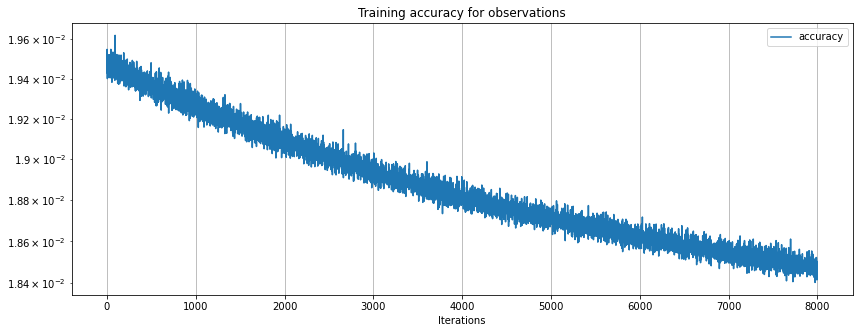

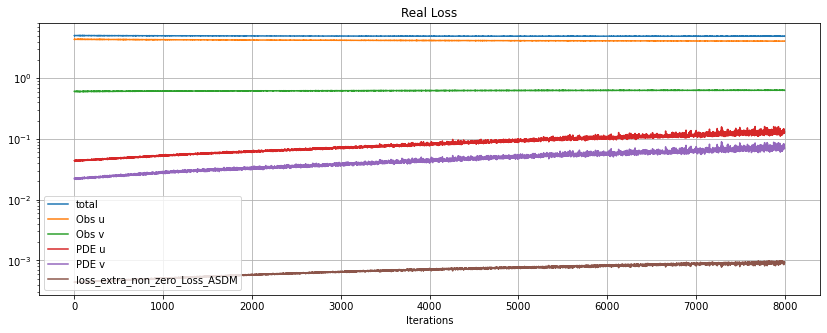

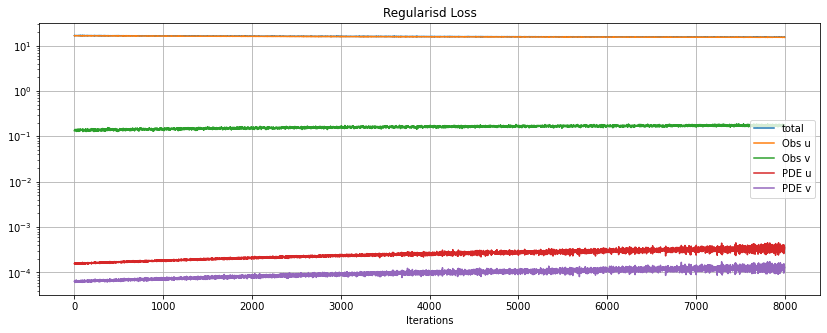

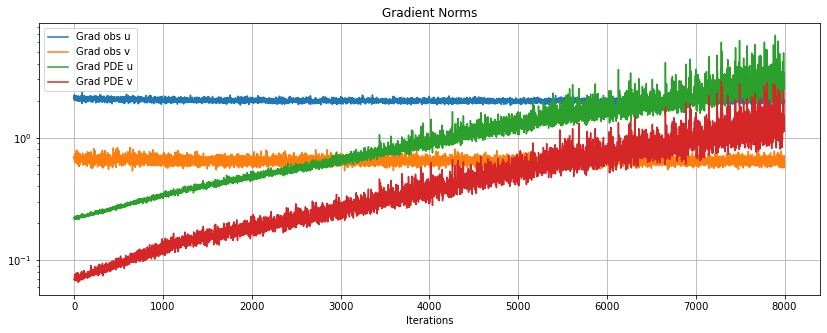

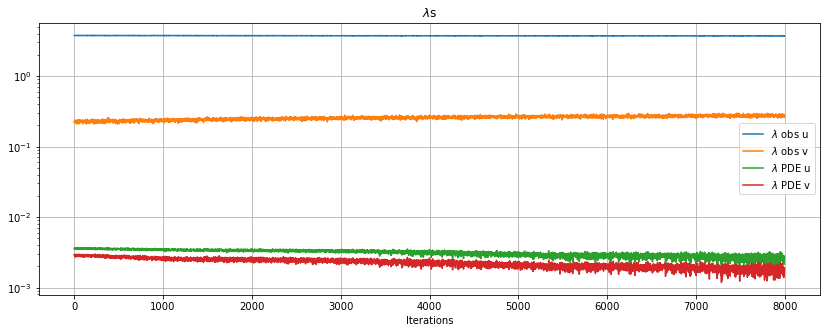

In [21]:
plot_result(merge_dict(results_KM_2, results_KM_2_2), start=4000)

In [43]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (32, 32)
L = (50, 50)
t = t_star#np.linspace(0, 100000, 256)

pde_lossKM_2.print_precision = '.12f'
print(pde_lossKM_2.trainables_str())

# Include the estimated params
expected_D_a = 0.005#0.001#0.001#0.001#0.1#0.01#0.005
expected_D_s = 0.2#0.015#0.05#0.1#20.0#2.0#0.2
D_a_ratio = expected_D_a/pde_lossKM_2.D_a.numpy()
D_s_ratio = expected_D_s/pde_lossKM_2.D_s.numpy()
D_a = pde_lossKM_2.D_a.numpy()#
D_s = pde_lossKM_2.D_s.numpy()#
D[0] = pde_lossKM_2.D_a.numpy()*D_a_ratio # D_a
D[1] = pde_lossKM_2.D_s.numpy()*D_s_ratio # D_s
beta[0] = pde_lossKM_2.sigma_a.numpy()*D_a_ratio# sigma_a
beta[1] = pde_lossKM_2.sigma_s.numpy()*D_s_ratio# sigma_s
gamma[0,0] = -pde_lossKM_2.mu_a.numpy()*D_a_ratio#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_lossKM_2.rho_a.numpy()*D_a_ratio,
          pde_lossKM_2.rho_s.numpy()*D_s_ratio,
          pde_lossKM_2.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
c02 = data[:, :, :, 0]
c2 = rdsolver.solve(c02, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
#c2_interp = rdsolver.viz.interpolate_concs(c2)

D_a: 0.018974072420 D_s: 0.050201196868 sigma_a: 0.000142421973 sigma_s: 0.006500958324 
mu_a: 0.038841060194 rho_a: 0.036836296705 rho_s: 0.006638112050 kappa_a: 0.202667572111 



100%|██████████| 512/512 [00:06<00:00, 77.66it/s] 


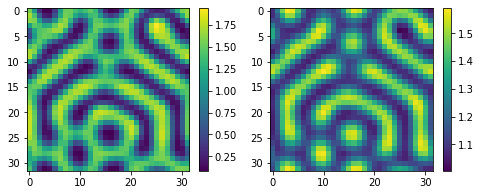

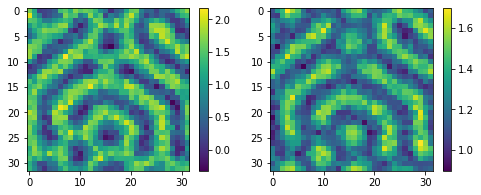

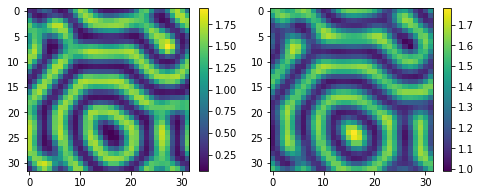

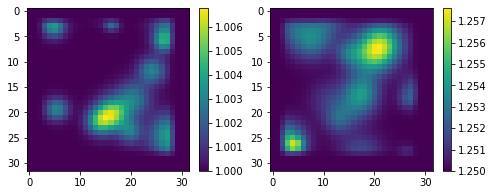

In [44]:
model_params_fig = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                'signal_to_noise':0.20,
                'shuffle':False}
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

dataset_fig = create_dataset(data, t_star, N, T, L, **model_params_fig)
obs_Y_fig = dataset_fig['obs_output']

_ = plt.figure(figsize=(8,4))
plt.title("Original")
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("20% Noise")
plt.subplot(121)
plt.imshow(obs_Y_fig[(T-1)*N:, 0].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(obs_Y_fig[(T-1)*N:, 1].reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c2[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c2[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.title("Initial condition")
plt.subplot(121)
plt.imshow(c2[0, :,:,0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c2[1, :,:,0])
plt.colorbar(shrink=.75)
plt.show()